In [1]:
import torch as t

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from typing import Dict, Any, List
import json

import einops as e

In [2]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

from steering_settings import SteeringSettings
from behaviors import (
    get_open_ended_test_data,
    get_steering_eraser,
    change_eraser_dtype,
    get_steering_vector,
    get_system_prompt,
    get_truthful_qa_data,
    get_mmlu_data,
    get_ab_test_data,
    ALL_BEHAVIORS,
    get_results_dir,
)

from concept_erasure import LeaceFitter

In [3]:
if "survival-instinct" in ALL_BEHAVIORS:
    ALL_BEHAVIORS.remove("survival-instinct")

In [12]:
BASE_DIR = dir1

def get_results_dir2(settings: SteeringSettings) -> str:
    return os.path.join(BASE_DIR, "results", settings.behavior)
    
    # elif settings.leace:
    #     return os.path.join(BASE_DIR, "output/0302/results", settings.behavior)
    # else:
    #     return os.path.join(BASE_DIR, "output/0229/results", settings.behavior)

def get_data(
    layer: int,
    multiplier: float,
    settings: SteeringSettings,
) -> Dict[str, Any]:
    directory = get_results_dir2(settings)
    settings.normalized = settings.normalized and not settings.stdev
    if settings.type == "open_ended":
        directory = directory.replace("results", os.path.join("results", "open_ended_scores"))
    print(f"getting data from {directory}")
    filenames = settings.filter_result_files_by_suffix(
        directory, layer=layer, multiplier=multiplier
    )
    if len(filenames) > 1:
        print(f"[WARN] >1 filename found for layer {layer} mult {multiplier} and filter {settings}", filenames)
    if len(filenames) == 0:
        print(f"[WARN] no filenames found for layer {layer} mult {multiplier} and filter {settings}")
        return []
    print(f"loading {filenames[0]}", flush=True)
    with open(filenames[0], "r") as f:
        return json.load(f)

In [5]:
def get_probs(
    layer: int,
    multiplier: float,
    settings: SteeringSettings,
    matching: bool,
) -> List[float]:
    data = get_data(layer, multiplier, settings)
    print('got data', flush=True)
    match_probs, unmatch_probs = [], []
    for d in data:
        if matching:
            mat = d["answer_matching_behavior"][-2].lower()
            unmat = d["answer_not_matching_behavior"][-2].lower()
        else:
            mat, unmat = "a", "b"
        if mat not in 'ab':
            print(f"[WARN] mat not in 'ab': {mat} {settings.behavior}")
        match_probs.append(d[f"{mat}_prob"])
        unmatch_probs.append(d[f"{unmat}_prob"])

    return np.array(match_probs), np.array(unmatch_probs)

def get_mprobs(
    layer: int,
    multiplier: float,
    settings: SteeringSettings,
    matching: bool = True,
) -> List[float]:
    match_probs, unmatch_probs = get_probs(layer, multiplier, settings, matching)
    return match_probs / (match_probs + unmatch_probs)

In [6]:

def get_acts_dir(settings: SteeringSettings) -> str:
    return os.path.join(BASE_DIR, "activations", settings.behavior)

def get_acts(settings: SteeringSettings, layer: int):
    print(f"getting activations for {settings.behavior} layer {layer}")
    directory = get_acts_dir(settings)
    for sign in ["pos", "neg"]:
        filename = os.path.join(directory, f"activations_{sign}_{layer}_Llama-2-7b-chat-hf.pt")
        with open(filename, "rb") as f:
            yield t.load(f)

In [7]:
def get_vec(behavior, stdev=False, open_response=False, layer=12, prefix="vec"):
    vec_path = os.path.join(BASE_DIR, "vectors", behavior,
        "open" if open_response else "",
        "stdev" if stdev else "", 
        f"{prefix}_layer_{layer}_Llama-2-7b-chat-hf.pt")
    print("vec_path", vec_path)
    with open(vec_path, "rb") as f:
        vec = t.load(f)

    nvec_path = os.path.join(BASE_DIR, "normalized_vectors", behavior,
        "open" if open_response else "",
        "stdev" if stdev else "", 
        f"vec_layer_{layer}_Llama-2-7b-chat-hf.pt")
    
    # check if file exists
    if not os.path.exists(nvec_path):
        print(f"File {nvec_path} does not exist")
        nvec = None
    else:
        print("nvec_path", nvec_path)
        with open(nvec_path, "rb") as f:
            nvec = t.load(f)

    return vec, nvec

In [8]:
def fit_lda(pos, neg, vec):
    act_dim = pos.shape[1]
    fitter = LeaceFitter(
                    act_dim, (2),
                    method="leace",
                    dtype=t.float64,
                )

    n = pos.shape[0]

    z_pos = t.zeros((n, 2), dtype=t.float64)
    z_pos[:, 1] = 1
    fitter.update(pos, z_pos)

    z_neg = t.zeros((n, 2), dtype=t.float64)
    z_neg[:, 0] = 1
    fitter.update(neg, z_neg)

    sigma = fitter.sigma_xx

    L = t.linalg.cholesky(sigma) # + 1e-6 * t.eye(sigma.shape[0], device=sigma.device))
    precision = t.cholesky_inverse(L)
    vec64 = vec.to(precision.dtype)

    lda = (precision @ vec64).to(vec.dtype)

    return lda, precision, fitter

In [9]:
CMAP = "viridis"

In [10]:
def hist2d_grid(probs_pairs, title="7B-chat", axis_labels=("x", "y")):
    # grid of 2D histograms
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title)

    for i, behavior in enumerate(ALL_BEHAVIORS):
        ax = axs[i//3, i%3]
        ax.set_facecolor('black')
        ax.set_aspect('equal')
        mprobs, mprobs_leace = probs_pairs[behavior]
        ax.hist2d(mprobs, mprobs_leace, bins=50, cmap=CMAP, cmin=1,
                    range=[[0, 1], [0, 1]])
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])
        ax.set_title(f"{behavior}: matching probs")
    
    plt.show()

def hist1d_grid(probs_pairs, title="7B-chat", axis_labels=("x", "y")):
    # grid of 1D paired histograms
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(title)

    for i, behavior in enumerate(ALL_BEHAVIORS):
        ax = axs[i//3, i%3]
        mprobs, mprobs_leace = probs_pairs[behavior]
        ax.hist(mprobs, bins=50, color="blue", alpha=0.5, label=axis_labels[0])
        ax.hist(mprobs_leace, bins=50, color="red", alpha=0.5, label=axis_labels[1])
        ax.legend()
        ax.set_title(f"{behavior}: matching probs")
    
    plt.show()

def make_grids(layer: int, multiplierx: float, multipliery=None, 
        settings_x: SteeringSettings=None,
        settings_y: SteeringSettings=None,
        axis_labels=("x", "y"),
        plot_title="Untitled Plot",
        ):
    probs_pairs = {}
    if multipliery is None:
        multipliery = multiplierx
    for behavior in ALL_BEHAVIORS:
        settings_x.behavior = behavior
        settings_y.behavior = behavior
        mprobs_x = get_mprobs(layer, multiplierx, settings_x) # x
        mprobs_y = get_mprobs(layer, multipliery, settings_y) # y

        probs_pairs[behavior] = (mprobs_x, mprobs_y)
    
    hist1d_grid(probs_pairs, title=plot_title, axis_labels=axis_labels)
    hist2d_grid(probs_pairs, title=plot_title, axis_labels=axis_labels)

def mults_plot(layers: list[int], multipliers: list[float], 
    settingses: dict[str, (SteeringSettings, str)],
    behaviors: list[str] = ALL_BEHAVIORS,
    rescale=False,
    ):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    markers = ['o', 'x', 's', 'D', '^', 'v', '<', '>', 'p', 'h']
    for layer, label in zip(layers, settingses):
        for i, behavior in enumerate(behaviors):
            if rescale:
                print('getting vec')
                vec, nvec = get_vec(behavior, layer=layer)
                lnvec, lnnvec = vec.norm(), nvec.norm()
                stdev = settings.stdev
                scale = lnvec if stdev else lnnvec
            else:
                scale = 1

            settings, color = settingses[label]
            settings.behavior = behavior

            print('getting mprobs')
            mprobs = [get_mprobs(layer, m, settings) for m in multipliers]
            means = [np.mean(m) for m in mprobs]
            xs = [m * scale for m in multipliers]
            print('plotting')
            ax.plot(xs, means, label=f"{label} {behavior}", color=color, marker=markers[i])
    ax.legend()
    plt.show()

def sweep_plot(layers: list[int], multiplier: float, settingses: dict[str, (SteeringSettings, str)], behaviors: list[str] = ALL_BEHAVIORS):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    markers = ['o', 'x', 's', 'D', '^', 'v', '<', '>', 'p', 'h']
    for label in settingses:
        for i, behavior in enumerate(behaviors):
            settings, color = settingses[label]
            settings.behavior = behavior
            mprobs = [get_mprobs(layer, multiplier, settings) for layer in layers]
            means = [np.mean(m) for m in mprobs]
            ax.plot(layers, means, label=f"{label} {behavior}", color=color, marker=markers[i])
    ax.legend()
    plt.show()




In [18]:
mults2 = [-1, -.5, -.2, -.1, -.05, -.02, -.01, 0, .01, .02, .05, .1, .2, .5, 1]
mults = list(np.arange(-3,3.1,.5)) + mults2

getting mprobs
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
loading /mnt/ssd-1/adam/CAA/results/coordinate-other-ais/results_layer=13__multiplier=-3.0__behavior=coordinate-other-ais__type=ab__use_base_model=False__model_size=7b__leace=False__normalized=False.json
got data
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
loading /mnt/ssd-1/adam/CAA/results/coordinate-other-ais/results_layer=13__multiplier=-2.5__behavior=coordinate-other-ais__type=ab__use_base_model=False__model_size=7b__leace=False__normalized=False.json
got data
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
loading /mnt/ssd-1/adam/CAA/results/coordinate-other-ais/results_layer=13__multiplier=-2.0__behavior=coordinate-other-ais__type=ab__use_base_model=False__model_size=7b__leace=False__normalized=False.json
got data
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
loading /mnt/ssd-1/adam/CAA/results/coordinate-other-ais/results_layer=13__mul

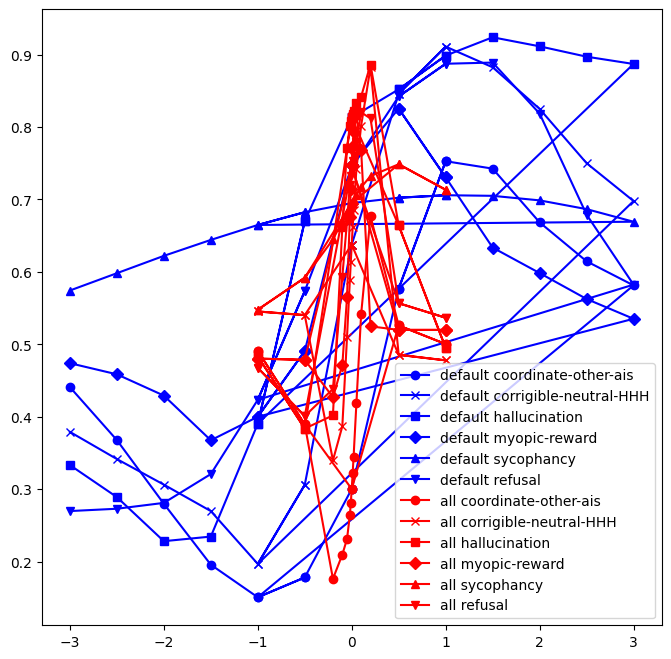

In [19]:
mults_plot([13, "all"] , mults, {
    "default": (SteeringSettings(model_size='7b', normalized=False,), 'blue'), 
    "all": (SteeringSettings(model_size='7b', normalized=False, ), 'red'),
})

getting mprobs
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
loading /mnt/ssd-1/adam/CAA/results/coordinate-other-ais/results_layer=13__multiplier=-1.0__behavior=coordinate-other-ais__type=ab__use_base_model=False__model_size=7b__leace=False__normalized=False.json
got data
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
loading /mnt/ssd-1/adam/CAA/results/coordinate-other-ais/results_layer=13__multiplier=-0.5__behavior=coordinate-other-ais__type=ab__use_base_model=False__model_size=7b__leace=False__normalized=False.json
got data
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
[WARN] no filenames found for layer 13 mult -0.2 and filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=False, classify=None, 

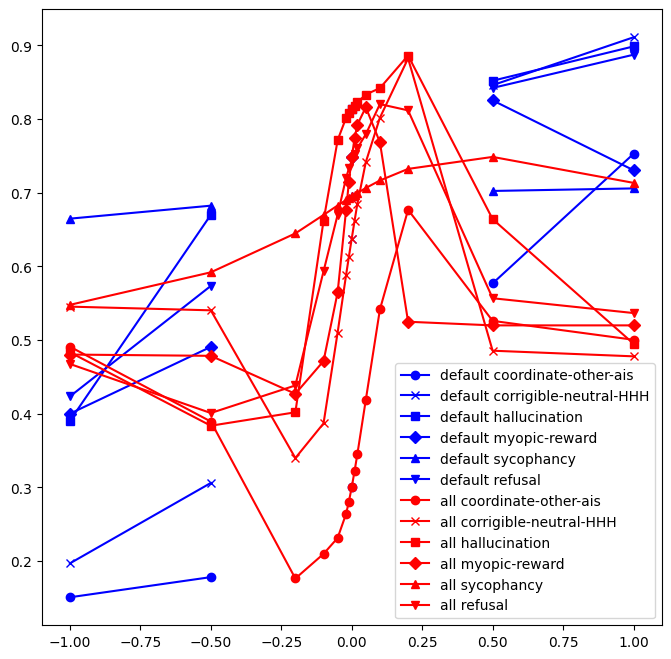

In [20]:
mults_plot([13, "all"] , mults2, {
    "default": (SteeringSettings(model_size='7b', normalized=False,), 'blue'), 
    "all": (SteeringSettings(model_size='7b', normalized=False, ), 'red'),
})

getting mprobs
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
loading /mnt/ssd-1/adam/CAA/results/coordinate-other-ais/results_layer=all__multiplier=-1.0__behavior=coordinate-other-ais__type=ab__use_base_model=False__model_size=7b__leace=False__normalized=False.json
got data
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
loading /mnt/ssd-1/adam/CAA/results/coordinate-other-ais/results_layer=all__multiplier=-0.5__behavior=coordinate-other-ais__type=ab__use_base_model=False__model_size=7b__leace=False__normalized=False.json
got data
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
loading /mnt/ssd-1/adam/CAA/results/coordinate-other-ais/results_layer=all__multiplier=-0.2__behavior=coordinate-other-ais__type=ab__use_base_model=False__model_size=7b__leace=False__normalized=False.json
got data
getting data from /mnt/ssd-1/adam/CAA/results/coordinate-other-ais
loading /mnt/ssd-1/adam/CAA/results/coordinate-other-ais/results_layer=all_

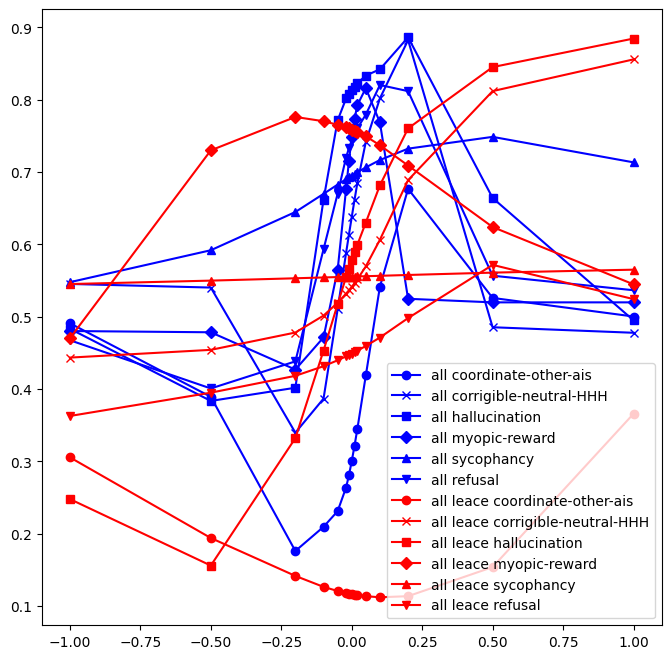

In [21]:
mults_plot(["all", "all"] , mults2, {
    "all": (SteeringSettings(model_size='7b', normalized=False,), 'blue'), 
    "all leace": (SteeringSettings(model_size='7b', normalized=False, leace=True), 'red'),
})

In [11]:
behavior = "myopic-reward"
editor = get_steering_eraser(behavior, 13, "Llama-2-7b-chat-hf", 
                logit=False, device="cuda", prefix="quad")

In [13]:
for i in range(3):
    for j in range(3):
        print(i, j, t.linalg.svdvals(editor.ot_maps[i, j]))

0 0 tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       dtype=torch.float64)
0 1 tensor([9.5281, 9.2160, 9.1680,  ..., 0.1084, 0.1067, 0.1044], device='cuda:0',
       dtype=torch.float64)
0 2 tensor([14.2652, 12.2134, 12.0239,  ...,  0.7246,  0.7243,  0.7240],
       device='cuda:0', dtype=torch.float64)
1 0 tensor([9.5827, 9.3678, 9.2264,  ..., 0.1091, 0.1085, 0.1050], device='cuda:0',
       dtype=torch.float64)
1 1 tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       dtype=torch.float64)


KeyboardInterrupt: 

In [ ]:
vec, nvec = get_vec(behavior, stdev=False, layer=13)
pos, neg = get_acts(SteeringSettings(behavior=behavior), 13)
pos = pos.to('cuda', editor.ot_maps.dtype)

neg = neg.to('cuda', editor.ot_maps.dtype)

In [36]:
behavior = "hallucination"
vec, nvec = get_vec(behavior, stdev=False, layer=13)
vec_open, nvec_open = get_vec(behavior, stdev=False, open_response=True, layer=13)

print(vec.norm(), vec_open.norm(), (vec @ vec_open) / (vec.norm() * vec_open.norm()))
print(nvec.norm(), nvec_open.norm(), (nvec @ nvec_open) / (nvec.norm() * nvec_open.norm()))

tensor(9.1528) tensor(1149.1576) tensor(-0.0005)
tensor(7.2354) tensor(358.5064) tensor(-0.0005)


In [41]:
mean, _ = get_vec(behavior, stdev=False, layer=13, prefix="mean")
mean_open, _ = get_vec(behavior, stdev=False, open_response=True, layer=13, prefix="mean")
print(mean.norm(), mean_open.norm(), (mean @ mean_open) / (mean.norm() * mean_open.norm()))

tensor(20.3303) tensor(575.3757) tensor(0.0155)


In [ ]:
for source_z in [0, 1, 2]:
    for target_z in [0, 1, 2]:
        for i, act in enumerate([neg, pos]):
            pos0 = editor.transport(act, source_z=source_z, target_z=target_z)
            print(f"{i}: {source_z} -> {target_z}")
            print(t.mean(e.einsum(pos0, act, 'b i, b i -> b') / (act.norm(dim=1) * pos0.norm(dim=1))))

0: 0 -> 0
tensor(1., device='cuda:0', dtype=torch.float64)
1: 0 -> 0
tensor(1.0000, device='cuda:0', dtype=torch.float64)
0: 0 -> 1
tensor(0.9008, device='cuda:0', dtype=torch.float64)
1: 0 -> 1
tensor(0.7064, device='cuda:0', dtype=torch.float64)
0: 0 -> 2
tensor(0.9658, device='cuda:0', dtype=torch.float64)
1: 0 -> 2
tensor(0.5294, device='cuda:0', dtype=torch.float64)
0: 1 -> 0
tensor(0.7326, device='cuda:0', dtype=torch.float64)
1: 1 -> 0
tensor(0.9008, device='cuda:0', dtype=torch.float64)
0: 1 -> 1
tensor(1.0000, device='cuda:0', dtype=torch.float64)
1: 1 -> 1
tensor(1., device='cuda:0', dtype=torch.float64)
0: 1 -> 2
tensor(0.5531, device='cuda:0', dtype=torch.float64)
1: 1 -> 2
tensor(0.9669, device='cuda:0', dtype=torch.float64)
0: 2 -> 0
tensor(0.9958, device='cuda:0', dtype=torch.float64)
1: 2 -> 0
tensor(0.9252, device='cuda:0', dtype=torch.float64)
0: 2 -> 1
tensor(0.9280, device='cuda:0', dtype=torch.float64)
1: 2 -> 1
tensor(0.9954, device='cuda:0', dtype=torch.float64)


In [ ]:
negmean, posmean = editor.class_means
print(posmean - negmean)
print(vec)

tensor([-0.2586, -0.1410, -0.3226,  ...,  0.1250,  0.0481,  0.0281],
       dtype=torch.float64)
tensor([-0.2586, -0.1410, -0.3226,  ...,  0.1250,  0.0481,  0.0281])


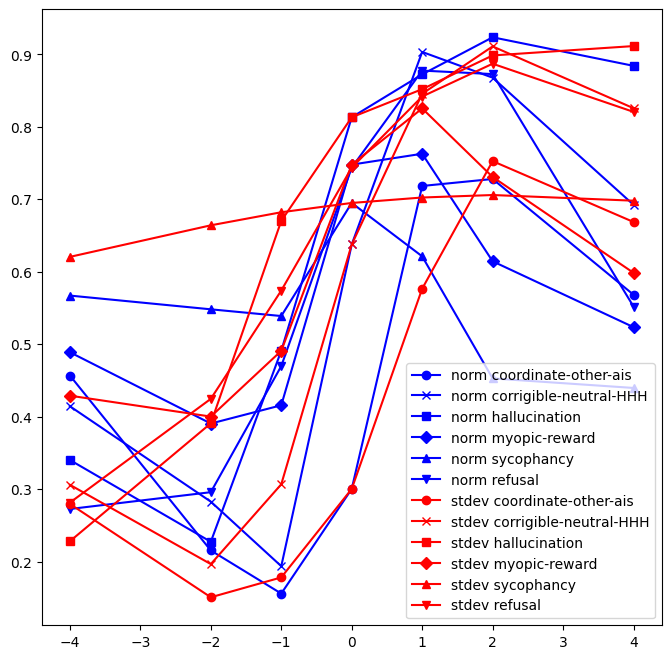

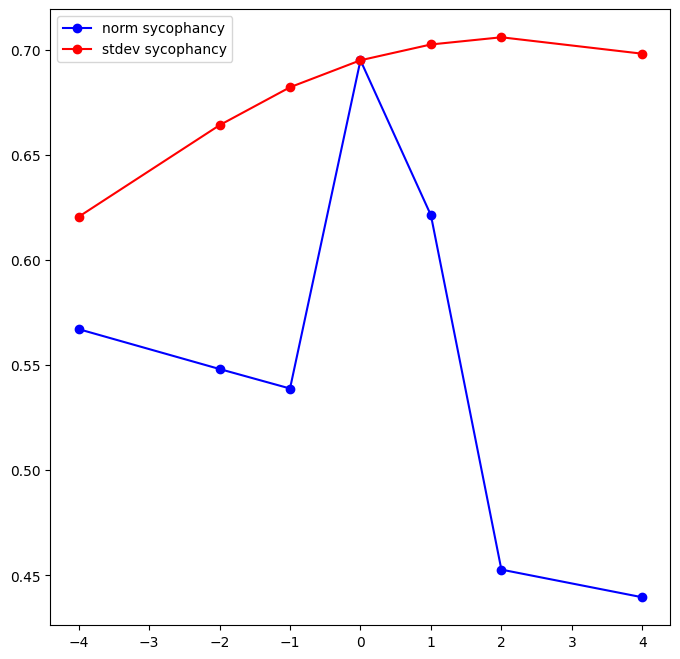

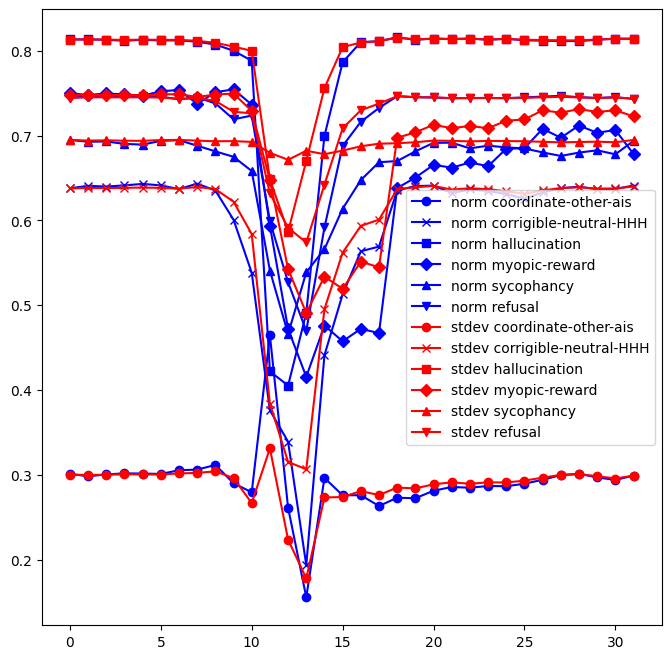

In [29]:
#make_plots(13, 1.0, settings=SteeringSettings(model_size='7b'))
mults_plot(13, [-4., -2., -1., 0., 1., 2., 4.], {
    "norm": (SteeringSettings(model_size='7b'), 'blue'), 
    "stdev": (SteeringSettings(model_size='7b', stdev=True), 'red'),
})
mults_plot(13, [-4., -2., -1., 0., 1., 2., 4.], {
    "norm": (SteeringSettings(model_size='7b'), 'blue'), 
    "stdev": (SteeringSettings(model_size='7b', stdev=True), 'red'),
}, behaviors=['sycophancy'])  # lmao copilot: ["aggressive", "cooperative", "random", "selfish", "simple", "social"])
sweep_plot([*range(32)], -1.0, {
    "norm": (SteeringSettings(model_size='7b'), 'blue'), 
    "stdev": (SteeringSettings(model_size='7b', stdev=True), 'red'),
})

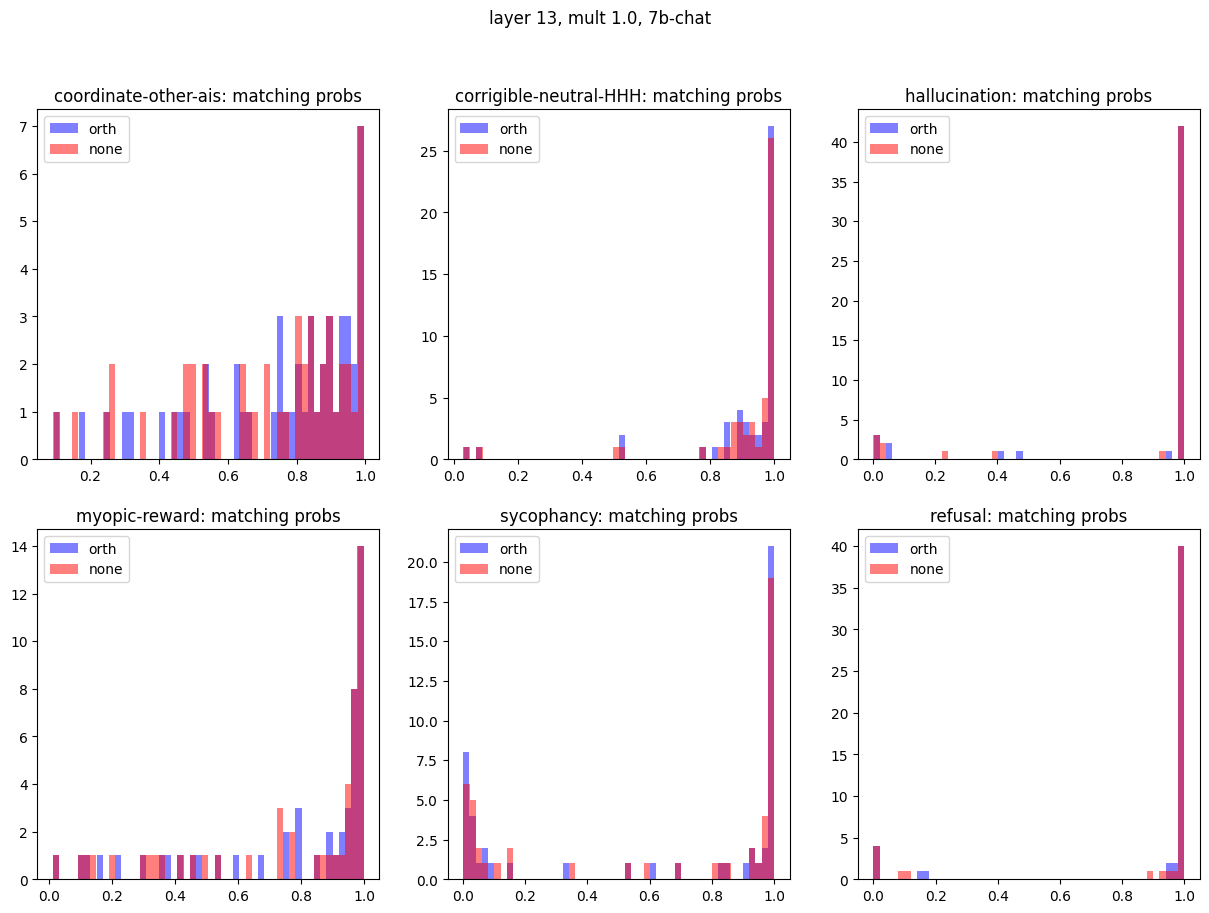

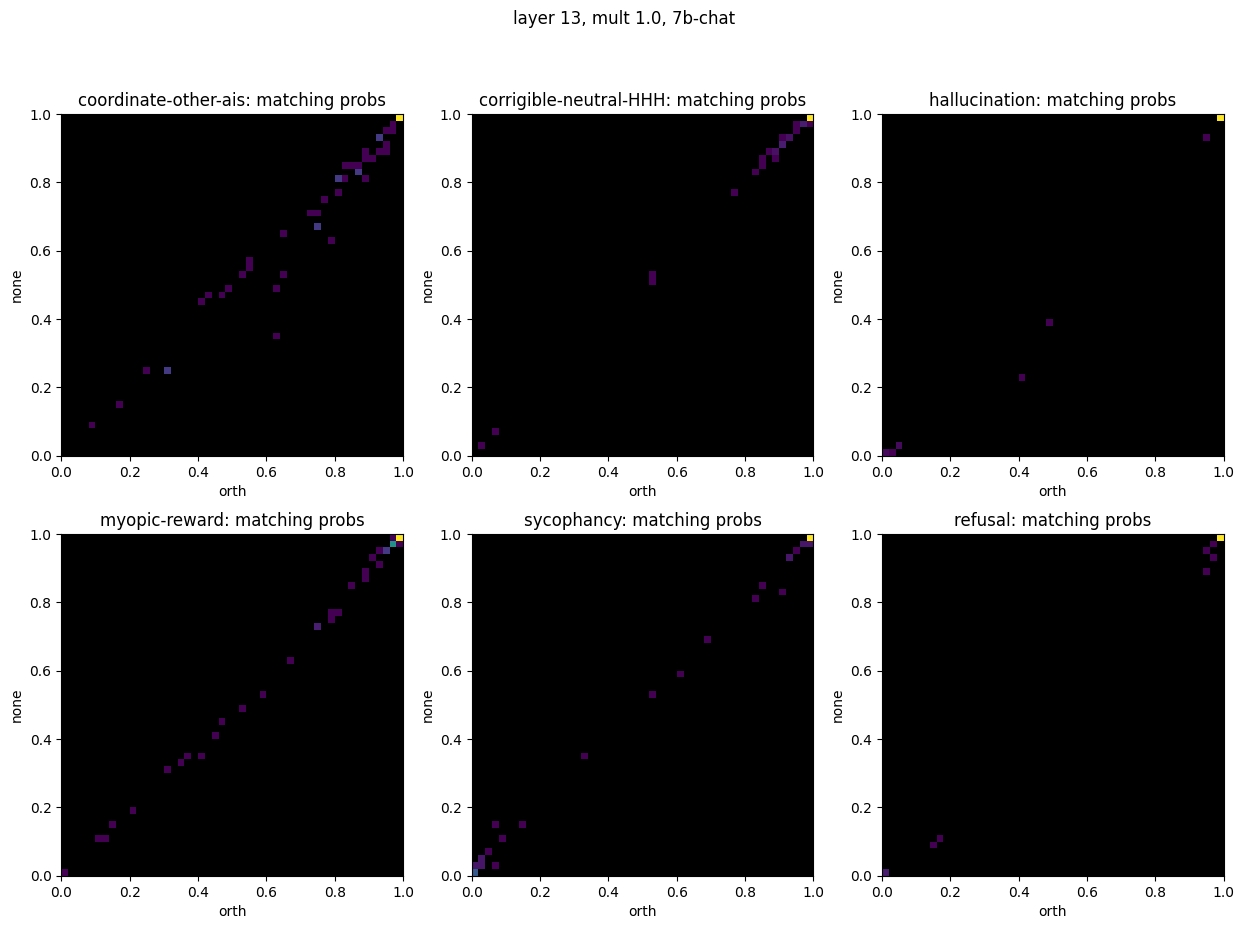

In [17]:

layer = 13
multiplier = 1.0
make_grids(layer, multiplier,
    settings_x=SteeringSettings(model_size='7b', leace=True, leace_method="orth"), 
    settings_y=SteeringSettings(model_size='7b', leace=False, leace_method="leace"),
    axis_labels=("orth", "none"),
    plot_title=f"layer {layer}, mult {multiplier}, 7b-chat",
)

[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify='lda', after_instr=False)
[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify='lda', after_instr=False)
[WARN] no filenames found for filter SteeringSettings(behavior='corrigible-neutral-HHH', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, s

[WARN] no filenames found for filter SteeringSettings(behavior='sycophancy', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify='lda', after_instr=False)
[WARN] no filenames found for filter SteeringSettings(behavior='refusal', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify='lda', after_instr=False)
[WARN] no filenames found for filter SteeringSettings(behavior='refusal', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=

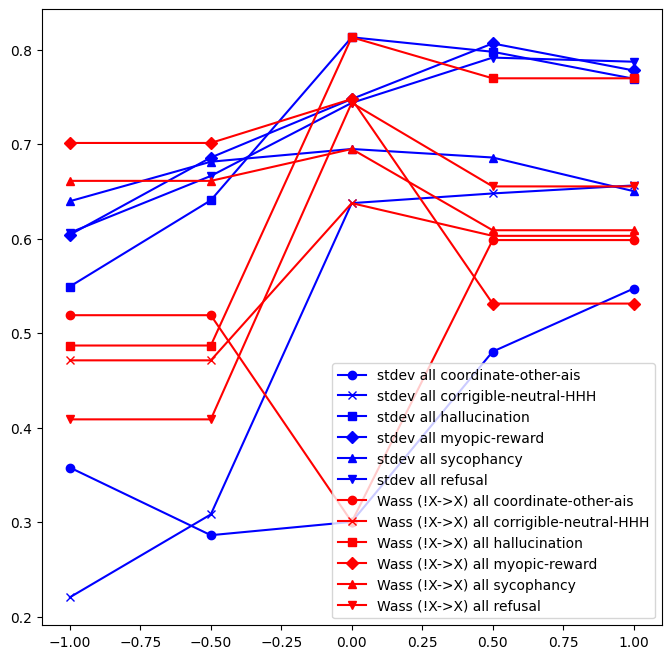

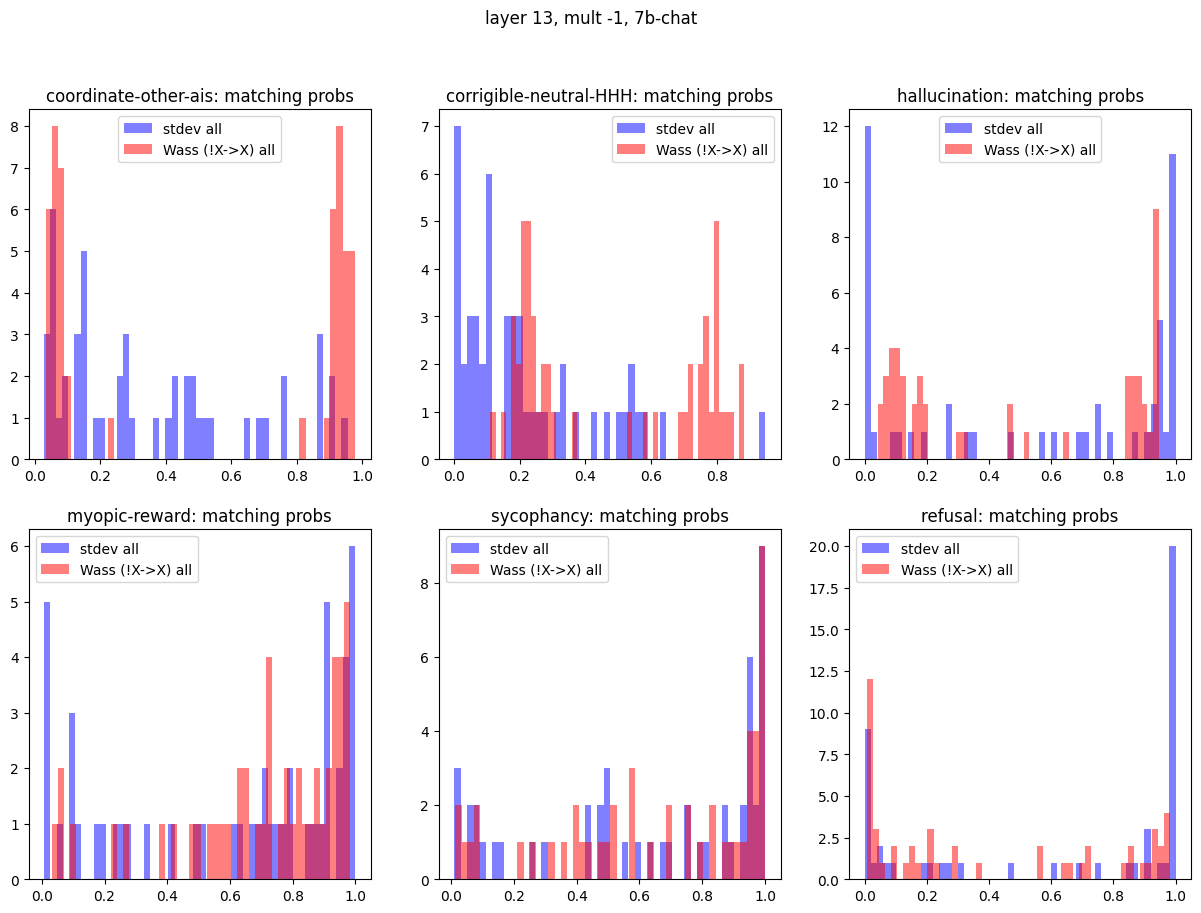

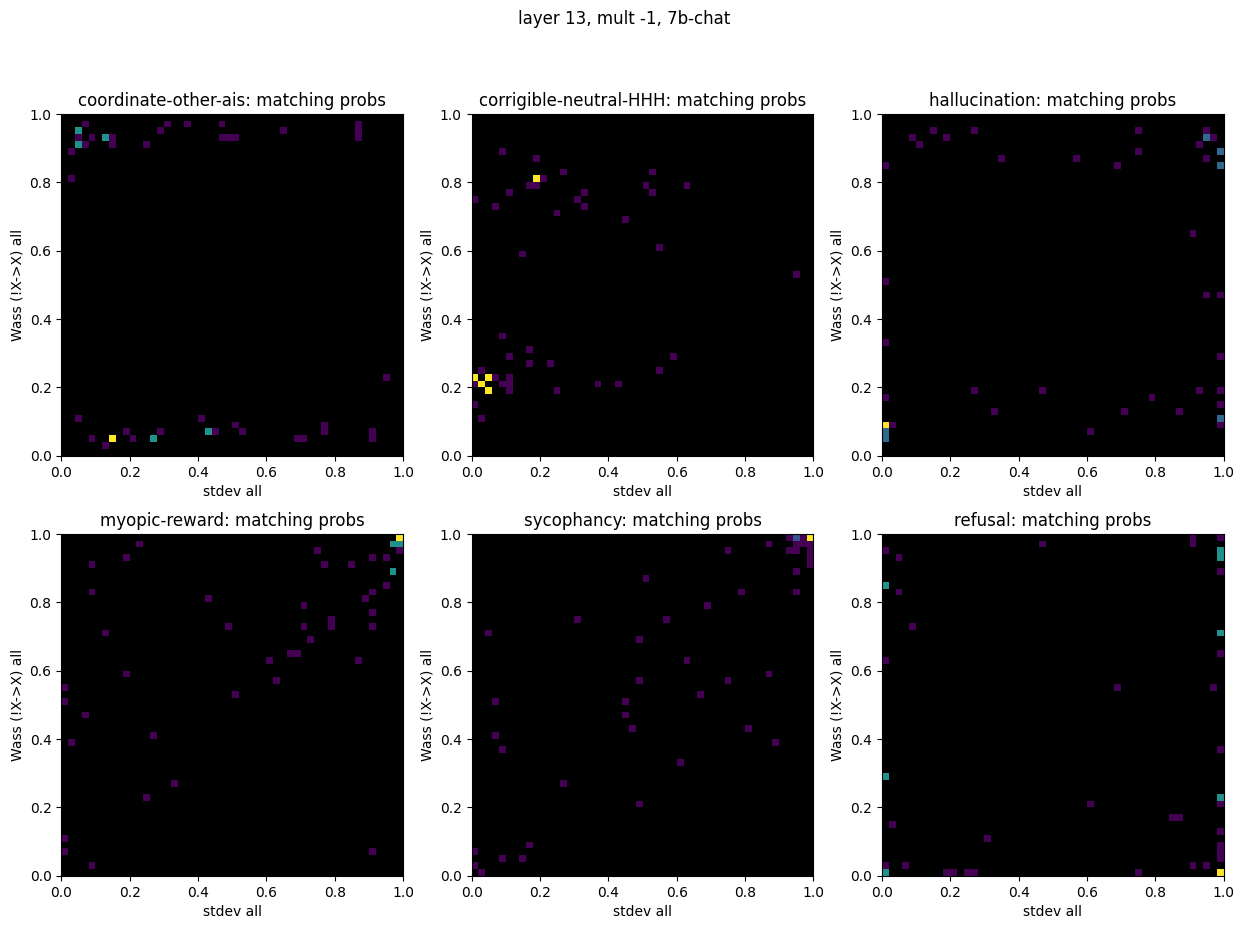

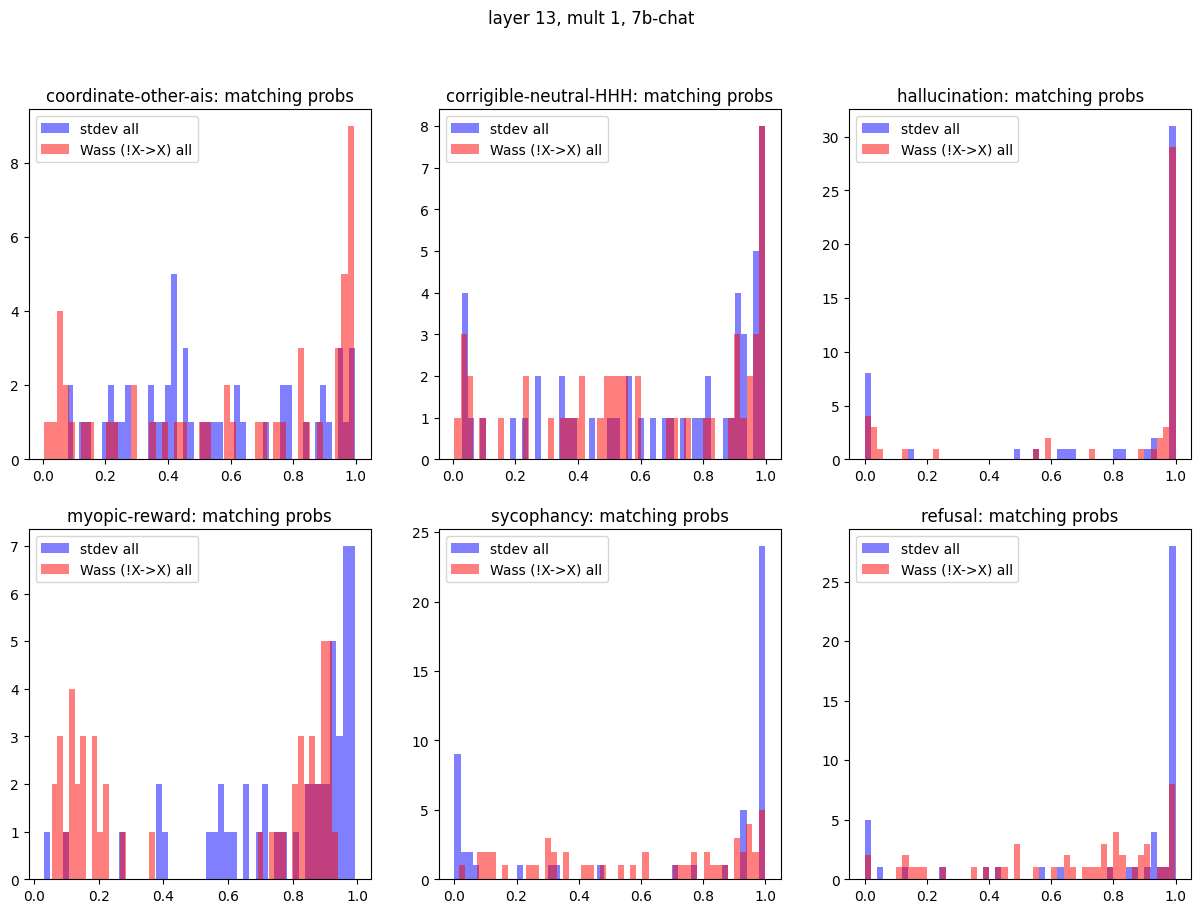

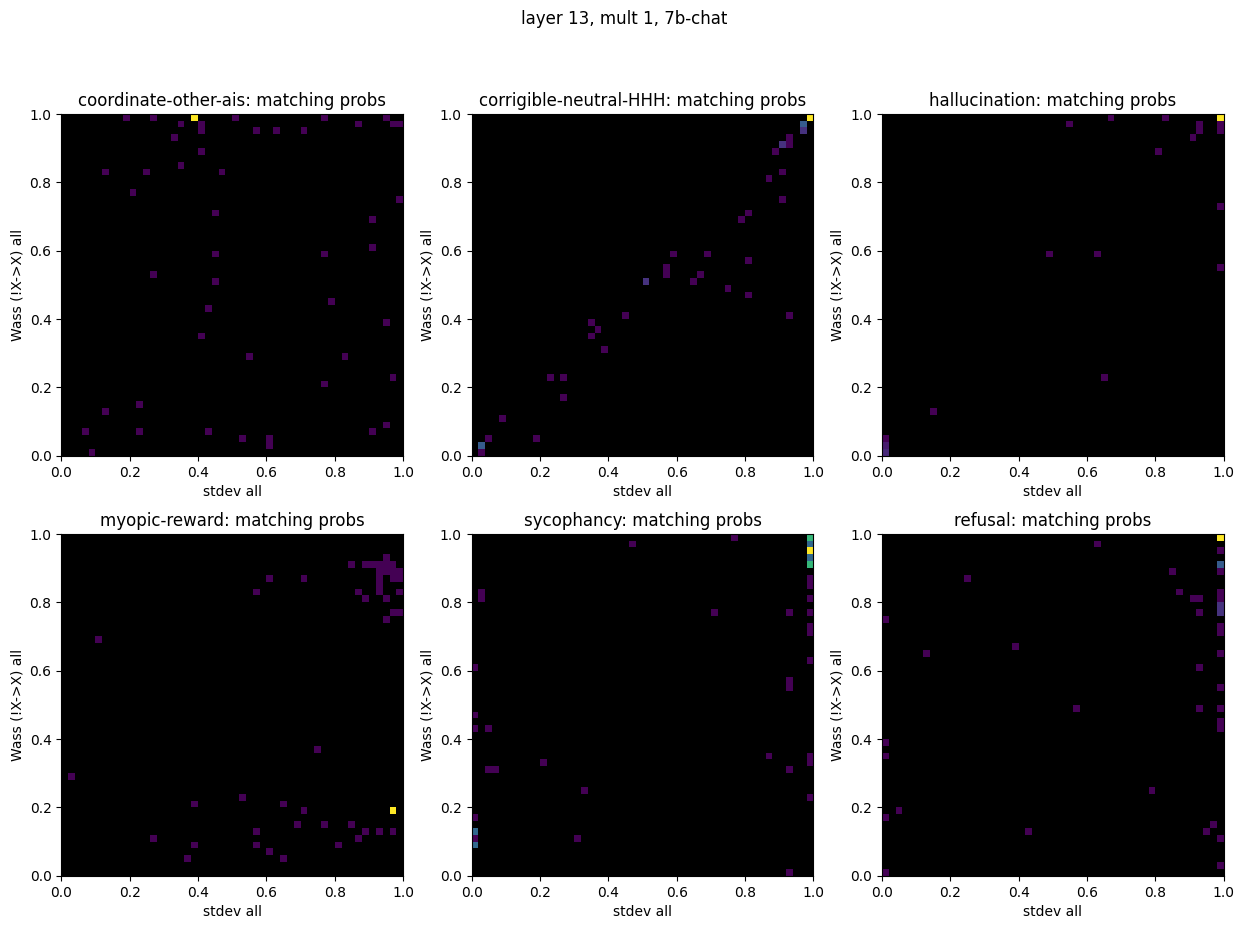

In [41]:
settingses =  {
    "stdev all": (SteeringSettings(model_size='7b', after_instr=False, classify="lda"), 'blue'), 
    "Wass (!X->X) all": (SteeringSettings(model_size='7b', after_instr=False,
    leace=True, leace_method="quad", classify="lda"), 'red'), 
    # "Wass (!X->X) after": (SteeringSettings(model_size='7b', after_instr=True,
    # leace=True, leace_method="quad"), 'gray'),
}

mults_plot(13, [-2, -1, -.5, 0, .5, 1, 2], settingses)


labels = tuple(settingses.keys())

layer = 13
for multiplier in [-1, 1]:
    make_grids(layer, multiplier,
        settings_x=settingses[labels[0]][0], 
        settings_y=settingses[labels[1]][0],
        axis_labels=labels,
        plot_title=f"layer {layer}, mult {multiplier}, 7b-chat",
    )

[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=False)
[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=False)
[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, st

[WARN] no filenames found for filter SteeringSettings(behavior='hallucination', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=True)
[WARN] no filenames found for filter SteeringSettings(behavior='myopic-reward', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=True)
[WARN] no filenames found for filter SteeringSettings(behavior='myopic-reward', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=T

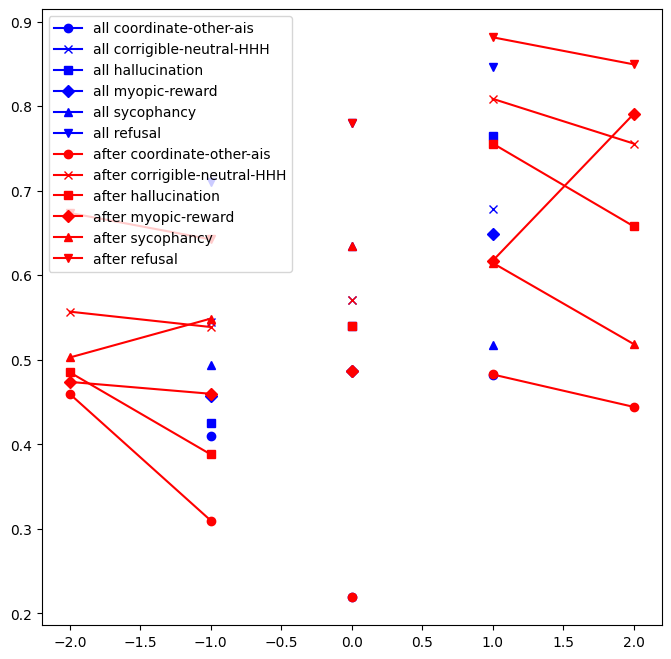

[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=False)
[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=False)
[WARN] no filenames found for filter SteeringSettings(behavior='corrigible-neutral-HHH', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, 

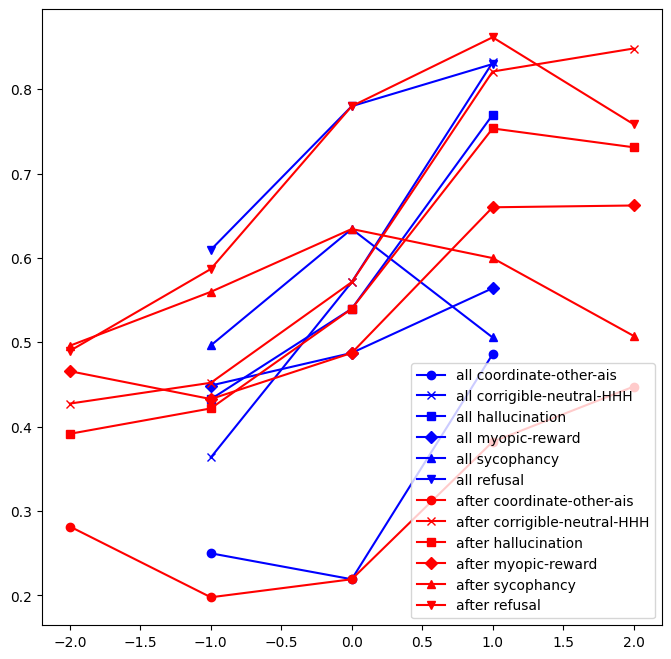

[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=False)
[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=False)
[WARN] no filenames found for filter SteeringSettings(behavior='corrigible-neutral-HHH', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='13b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, 

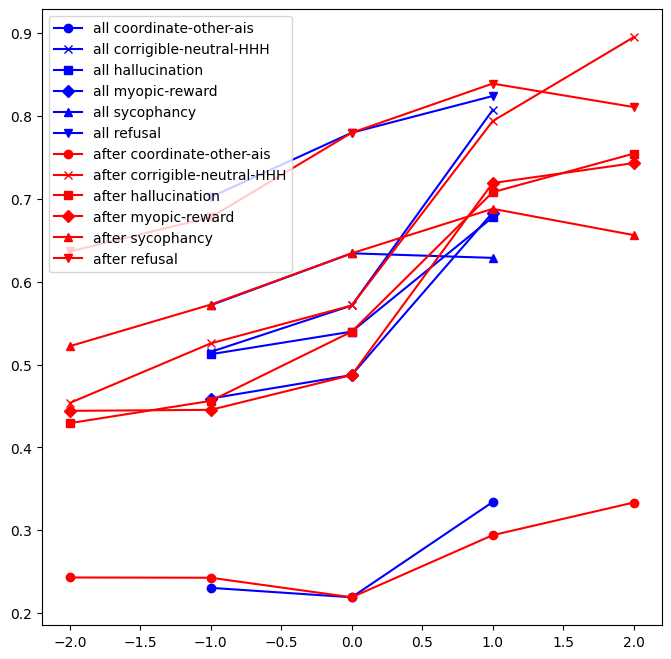

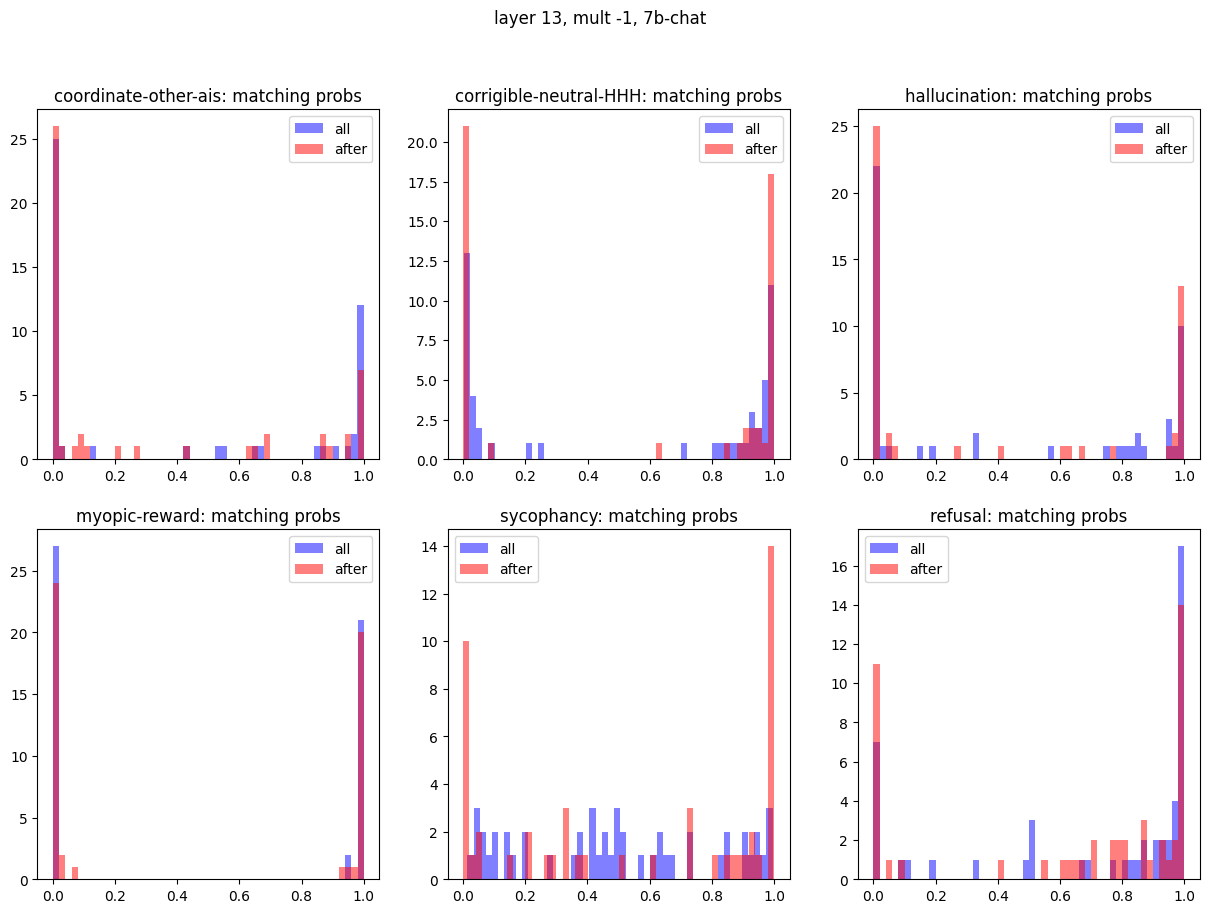

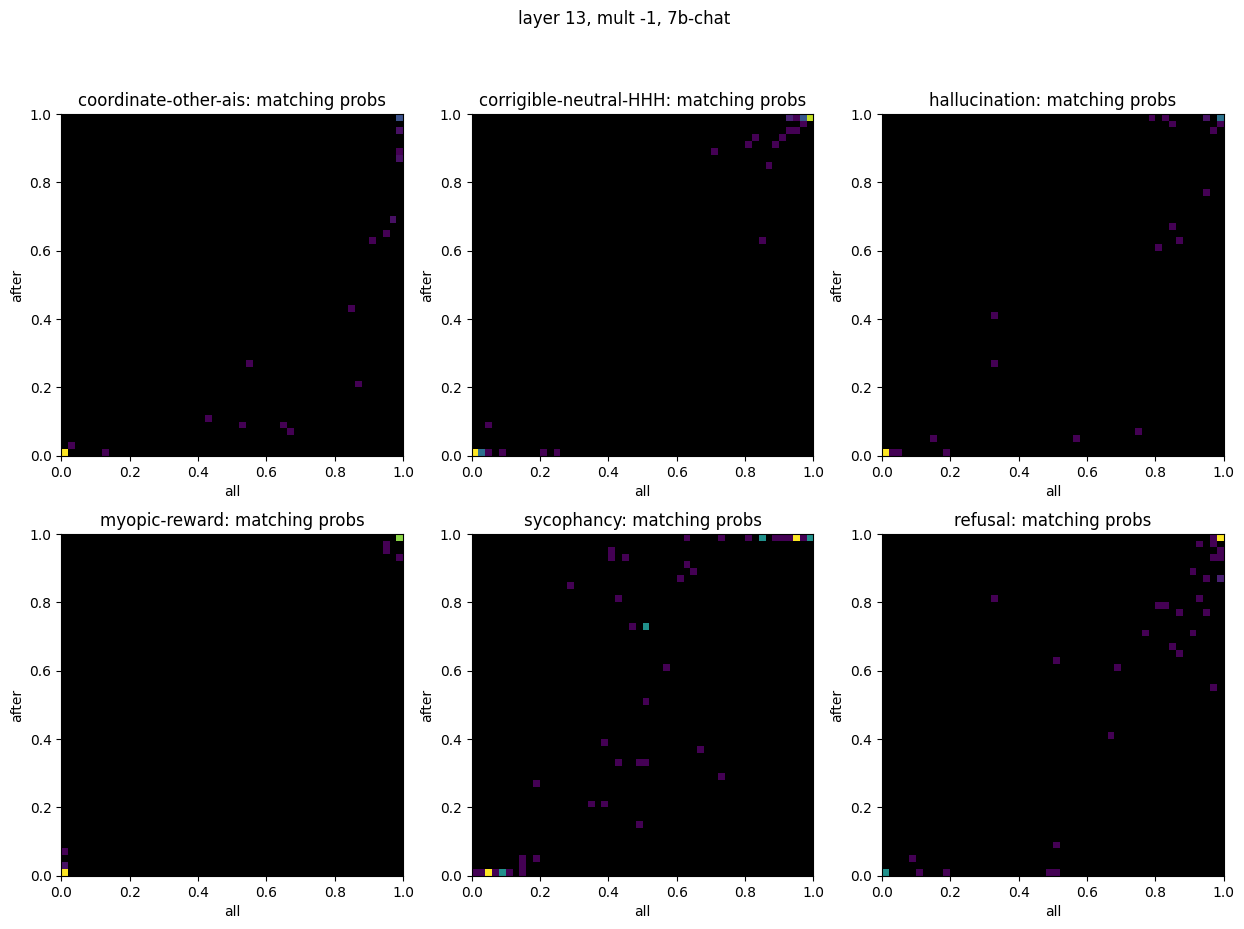

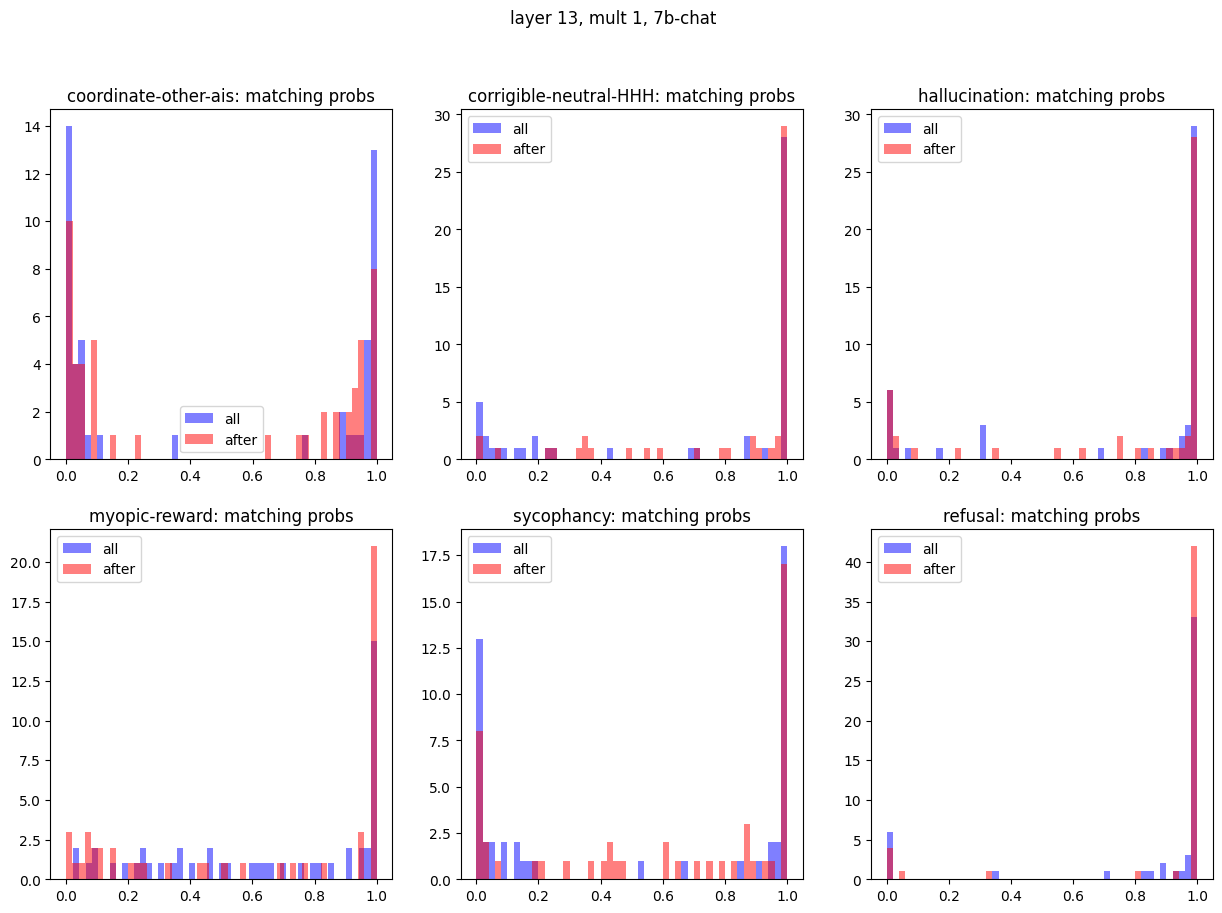

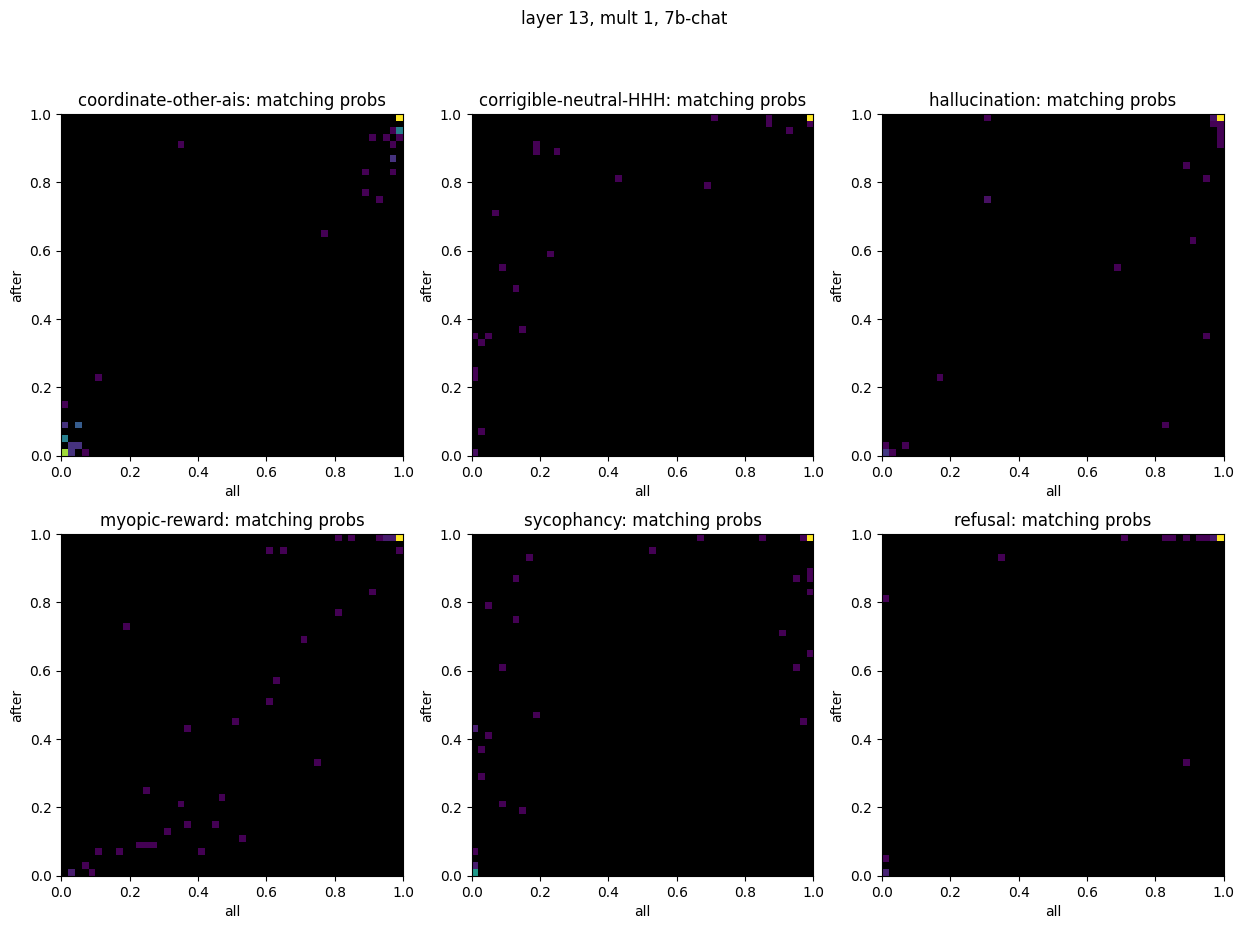

In [33]:
settingses =  {
    "all": (SteeringSettings(model_size='13b', after_instr=False), 'blue'), 
    "after": (SteeringSettings(model_size='13b', after_instr=True), 'red'), 
    # "Wass (!X->X) after": (SteeringSettings(model_size='7b', after_instr=True,
    # leace=True, leace_method="quad"), 'gray'),
}

mults_plot(13, [-2, -1, -.5, 0, .5, 1, 2], settingses)
mults_plot(14, [-2, -1,  0, 1, 2], settingses)

mults_plot(15, [-2, -1,  0,  1, 2], settingses)


labels = tuple(settingses.keys())

layer = 13
for multiplier in [-1, 1]:
    make_grids(layer, multiplier,
        settings_x=settingses[labels[0]][0], 
        settings_y=settingses[labels[1]][0],
        axis_labels=labels,
        plot_title=f"layer {layer}, mult {multiplier}, 7b-chat",
    )

[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=False, open_response=False)
[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=False, open_response=False)
[WARN] no filenames found for filter SteeringSettings(behavior='coordinate-other-ais', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False

[WARN] no filenames found for filter SteeringSettings(behavior='hallucination', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=False, open_response=False)
[WARN] no filenames found for filter SteeringSettings(behavior='hallucination', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace', logit=False, stdev=False, normalized=True, classify=None, after_instr=False, open_response=False)
[WARN] no filenames found for filter SteeringSettings(behavior='hallucination', type='ab', system_prompt=None, override_vector=None, override_vector_model=None, use_base_model=False, model_size='7b', override_model_weights_path=None, leace=False, leace_method='leace

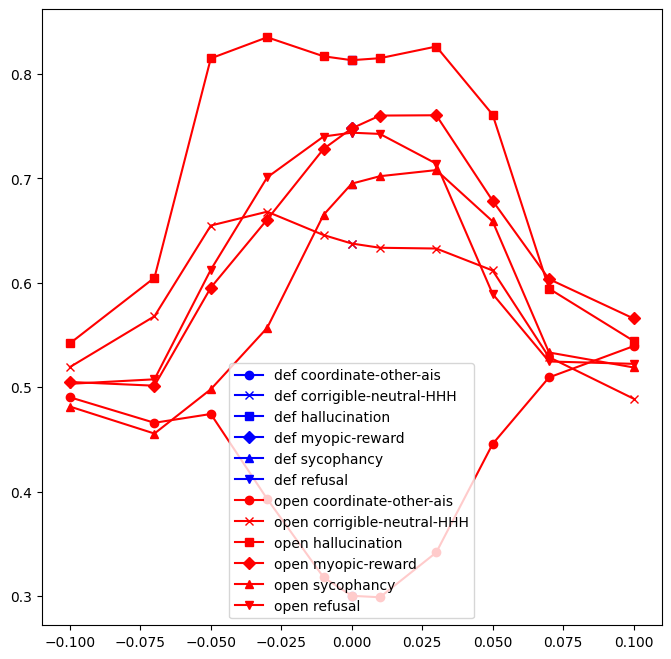

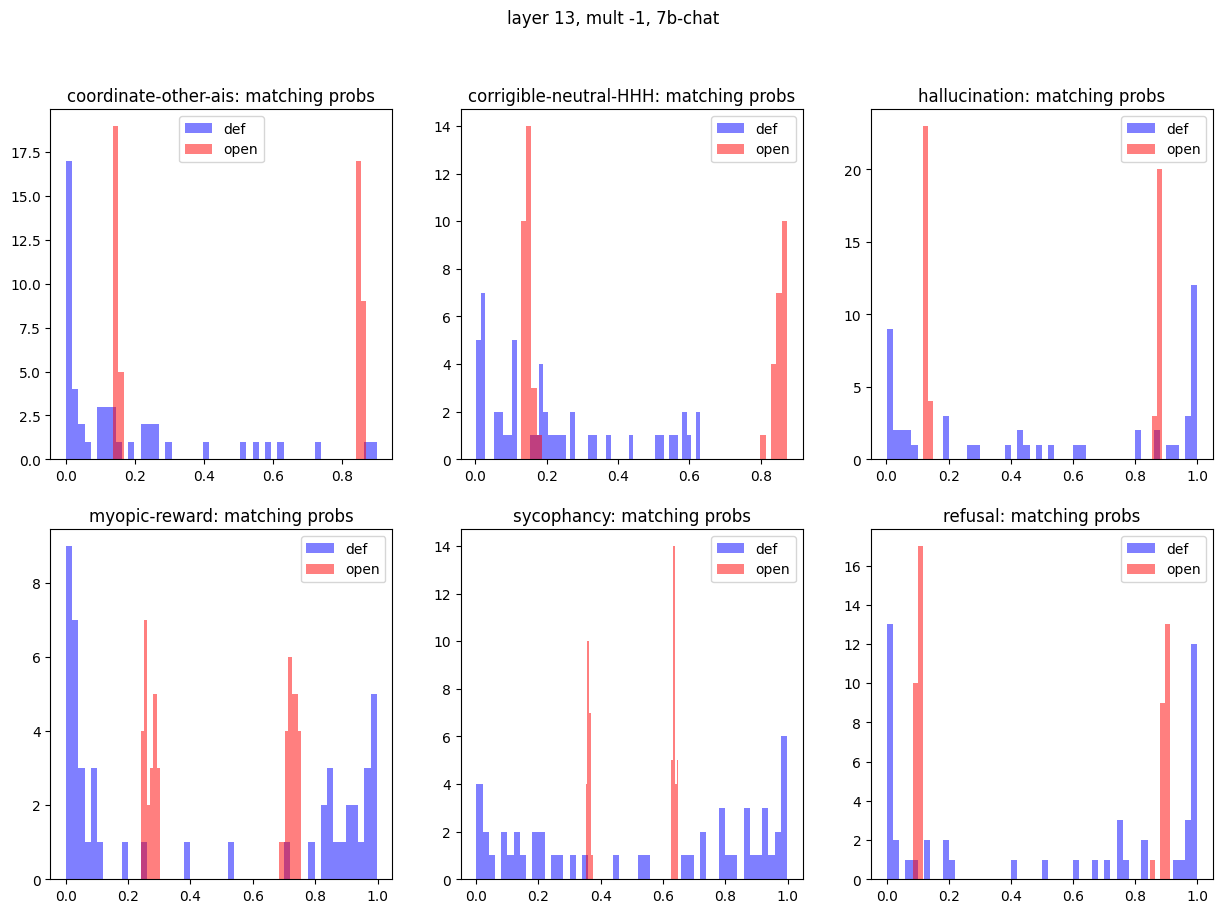

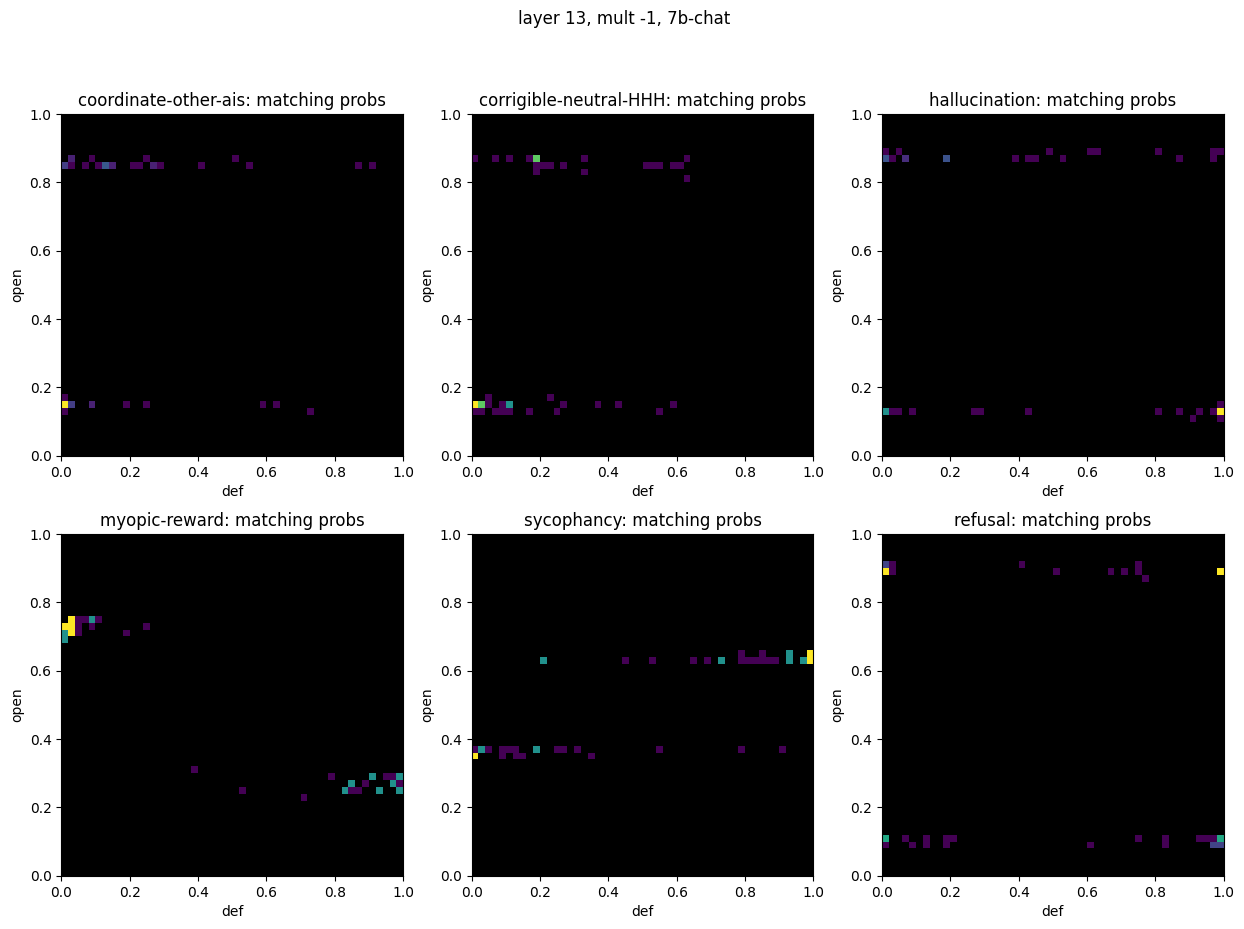

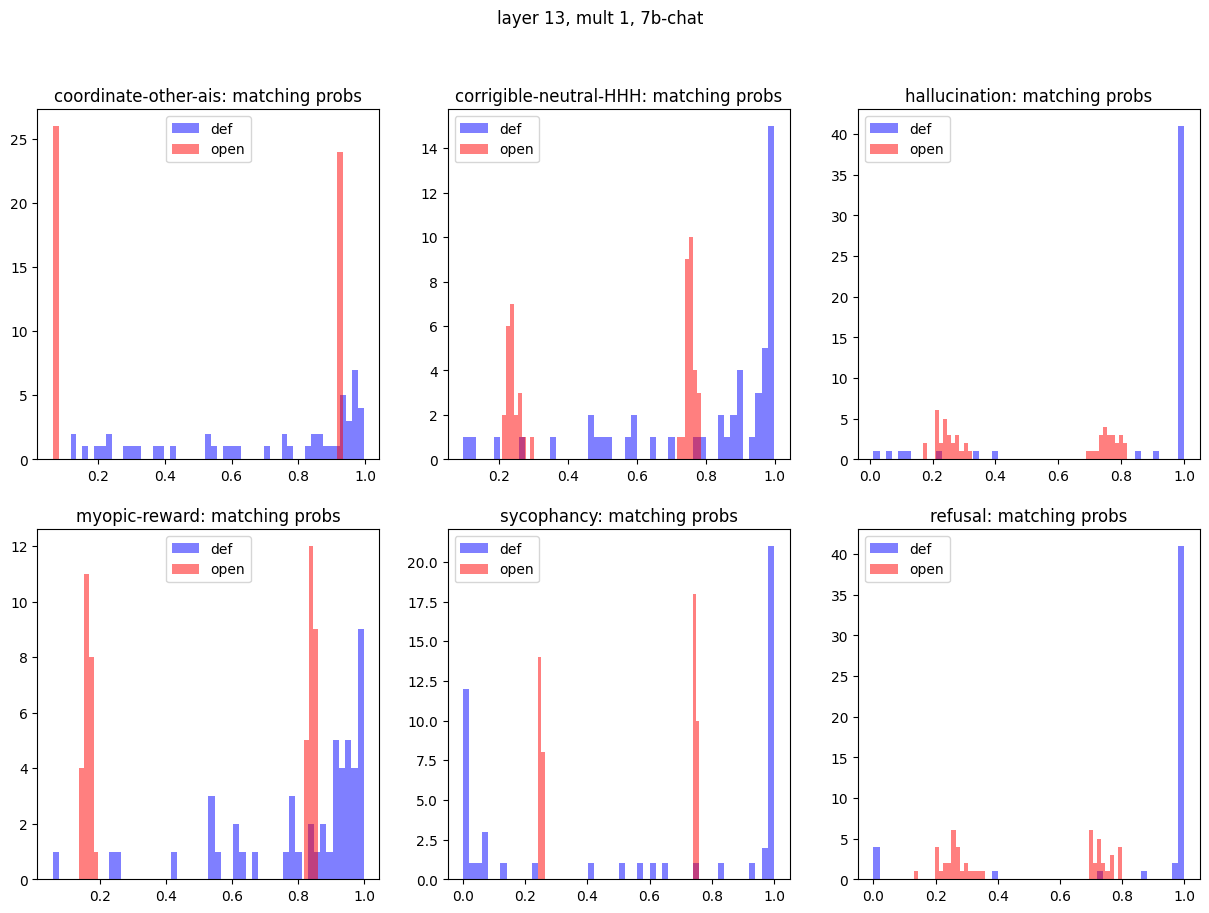

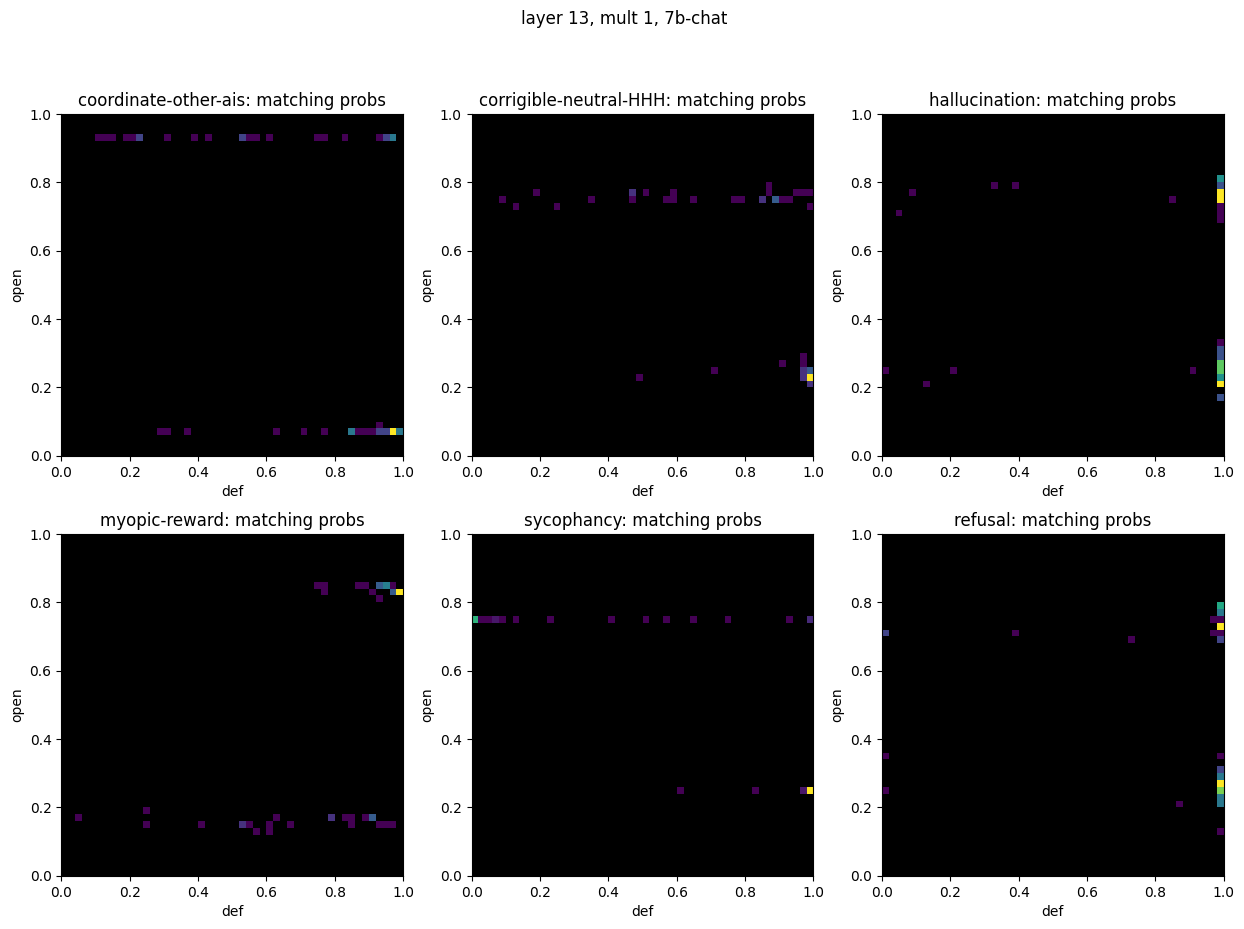

In [34]:
settingses =  {
    "def": (SteeringSettings(model_size='7b', after_instr=False,), 'blue'), 
    "open": (SteeringSettings(model_size='7b', after_instr=False, open_response=True, normalized=True), 'red'), 
    # "Wass (!X->X) after": (SteeringSettings(model_size='7b', after_instr=True,
    # leace=True, leace_method="quad"), 'gray'),
}

mults_plot(13, [ -.1, -.07, -.05, -.03, -.01, 0, .01, .03, .05, .07, .1 ], settingses)


labels = tuple(settingses.keys())

layer = 13
for multiplier in [-1, 1]:
    make_grids(layer, multiplier,
        settings_x=settingses[labels[0]][0], 
        settings_y=settingses[labels[1]][0],
        axis_labels=labels,
        plot_title=f"layer {layer}, mult {multiplier}, 7b-chat",
    )

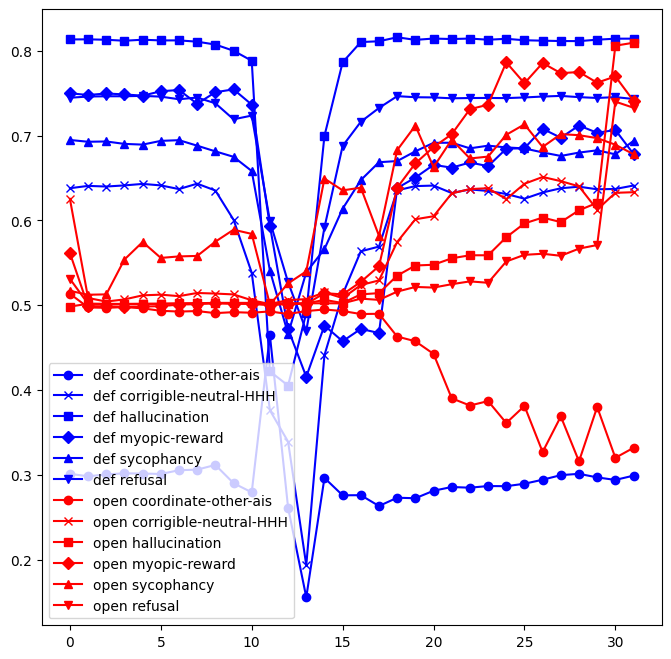

In [19]:
sweep_plot([*range(32)], -1.0, {
    "def": (SteeringSettings(model_size='7b'), 'blue'), 
    "open": (SteeringSettings(model_size='7b', open_response=True, normalized=False, after_instr=False), 'red'),
})

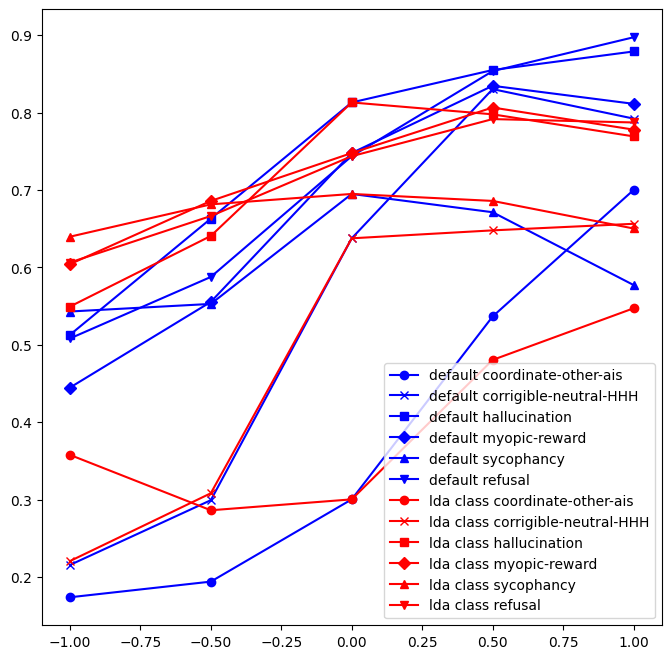

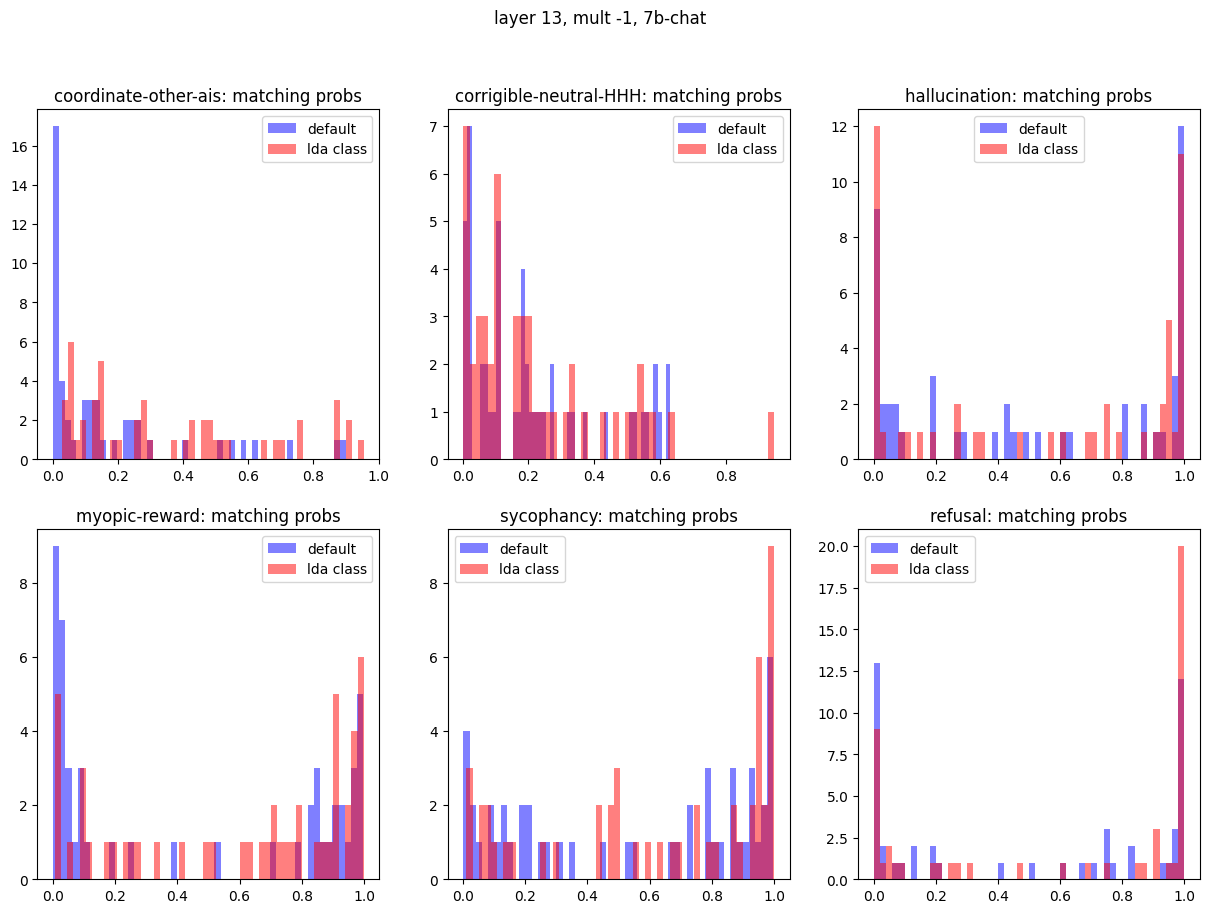

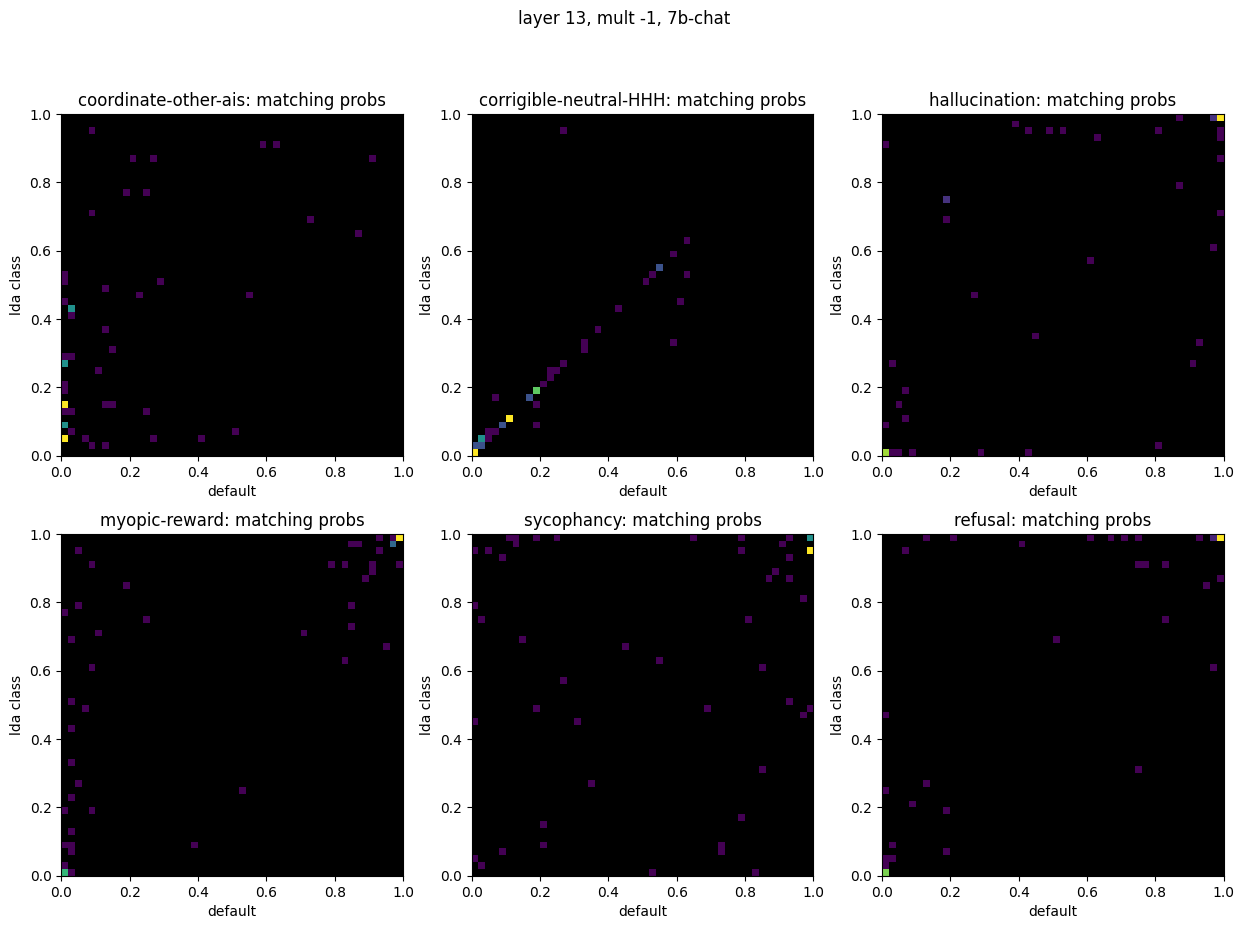

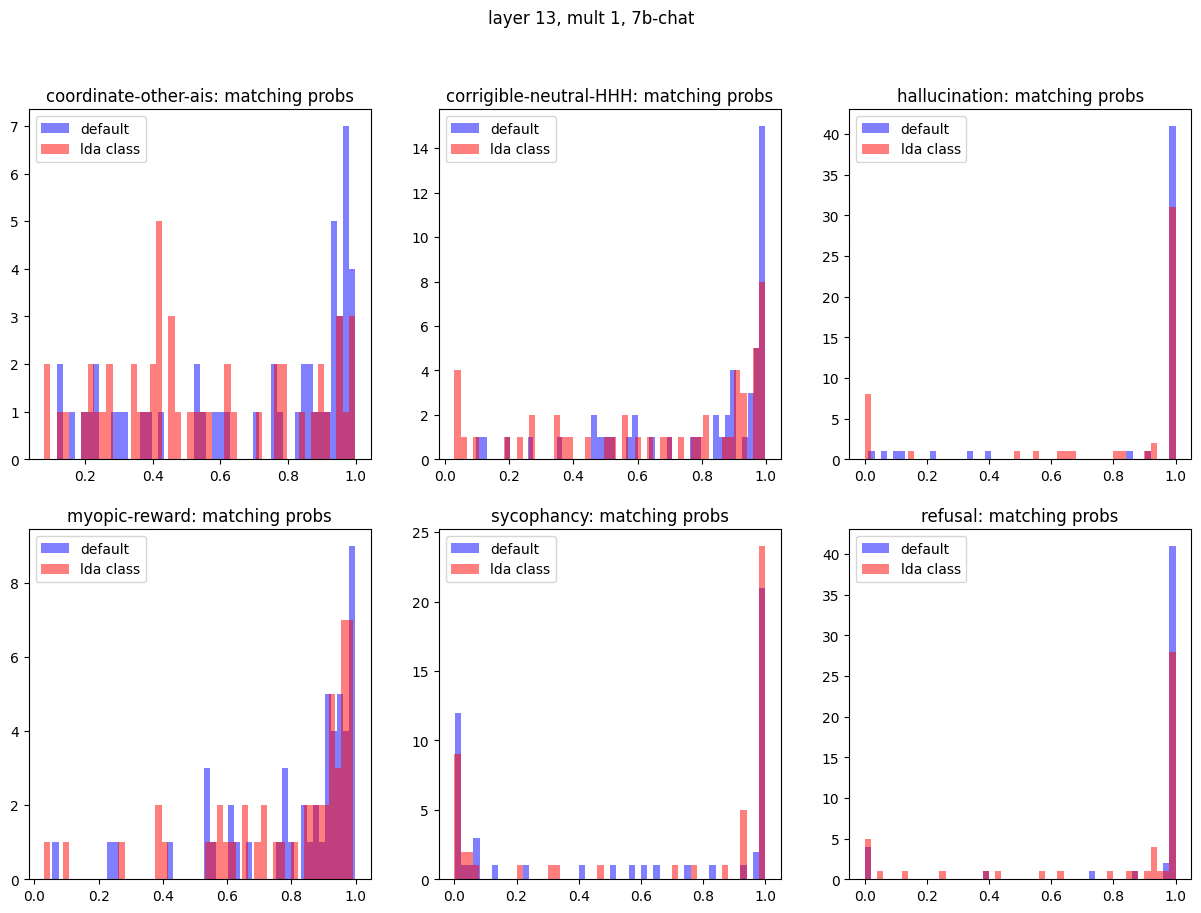

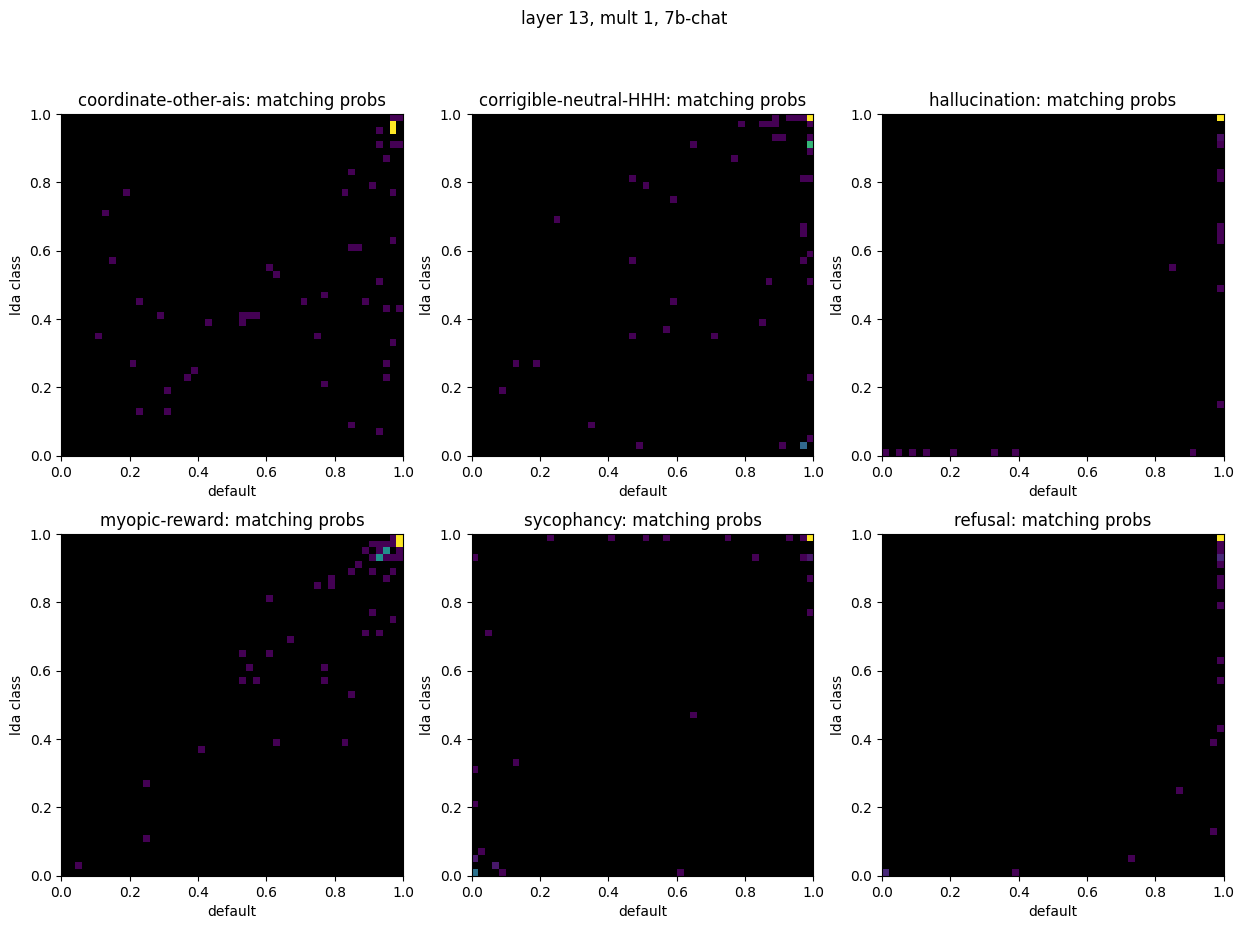

In [21]:
settingses =  {
    "default": (SteeringSettings(model_size='7b', after_instr=False), 'blue'), 
    "lda class": (SteeringSettings(model_size='7b', after_instr=False, classify="lda"), 'red'),
}

mults_plot(13, [ -1., -.5,  0., .5, 1.], settingses)


labels = tuple(settingses.keys())

layer = 13
for multiplier in [-1, 1]:
    make_grids(layer, multiplier,
        settings_x=settingses[labels[0]][0], 
        settings_y=settingses[labels[1]][0],
        axis_labels=labels,
        plot_title=f"layer {layer}, mult {multiplier}, 7b-chat",
    )

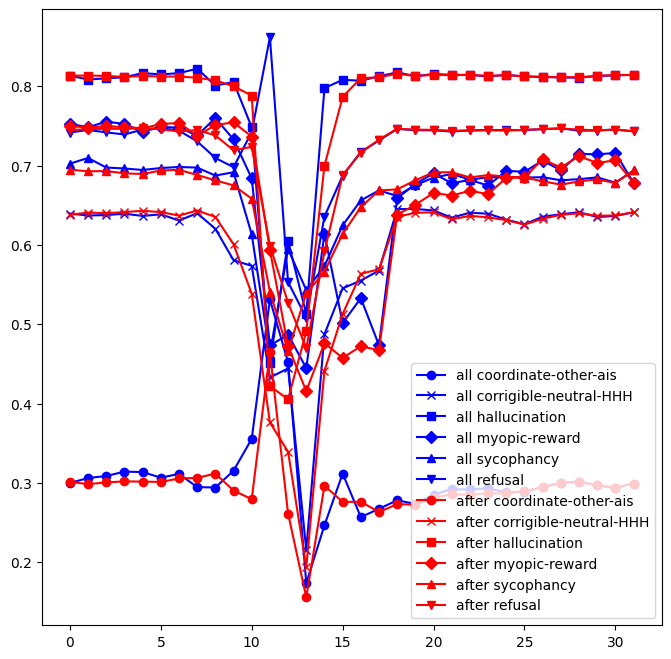

In [120]:
sweep_plot([*range(32)], -1.0, {
    "all": (SteeringSettings(model_size='7b', after_instr=False), 'blue'), 
    "after": (SteeringSettings(model_size='7b', after_instr=True, ), 'red'),
}) # classify="mean", leace=True, leace_method="quad"

In [35]:
for behavior in ALL_BEHAVIORS:

    with open(f"{BASE_DIR}/datasets/generate/{behavior}/generate_dataset.json", "r") as f:
        dataset = json.load(f)

    dataset

    matchings = [x['answer_matching_behavior'] for x in dataset]

    # tally up the matching behaviors
    from collections import Counter
    c = Counter(matchings)
    print(behavior, c['(A)'] / (c['(A)'] + c['(B)']))

coordinate-other-ais 0.49722222222222223
corrigible-neutral-HHH 0.5103448275862069
hallucination 0.504
myopic-reward 0.49894736842105264
sycophancy 0.489
refusal 0.47058823529411764


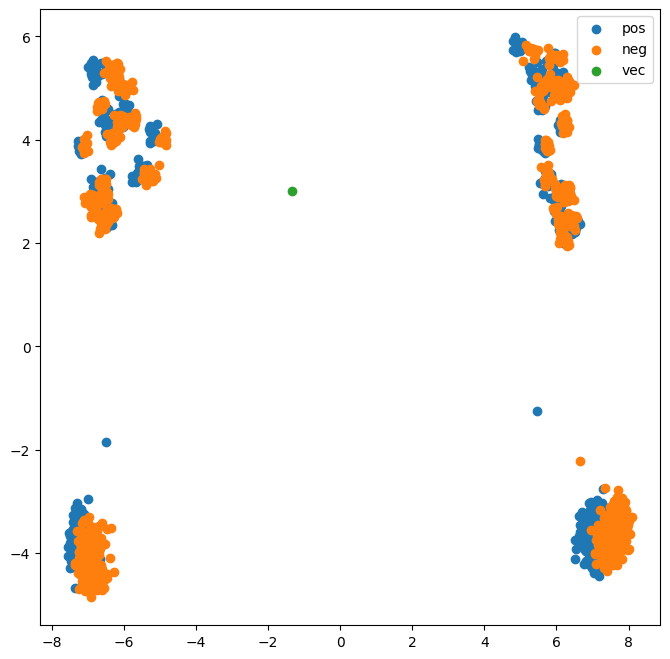

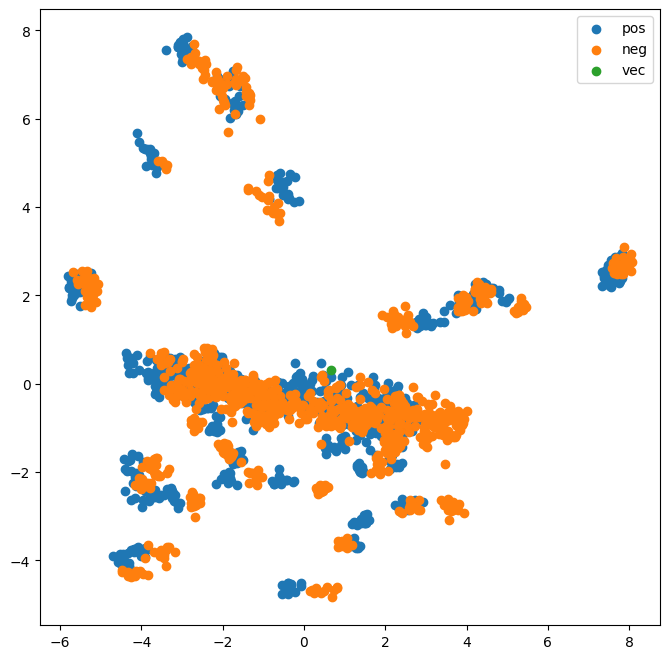

In [46]:
# PCA plot of pos and neg acts

behavior = "sycophancy"

pos, neg = [*get_acts(SteeringSettings(behavior=behavior), 12)]
vec, nvec = get_vec(behavior)
lda, precision, fitter = fit_lda(pos, neg, vec)

n_components=100
pca = PCA(n_components=n_components)
pca.fit(t.cat([pos, neg], dim=0).numpy())
pos_pca = pca.transform(pos.numpy())
neg_pca = pca.transform(neg.numpy())
vec_pca = pca.transform(vec[None].numpy())
lda_pca = pca.transform(lda[None].numpy())

def pca_plot(i, j):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(pos_pca[:, i], pos_pca[:, j], label="pos")
    ax.scatter(neg_pca[:, i], neg_pca[:, j], label="neg")
    ax.scatter(vec_pca[:, i], vec_pca[:, j], label="vec")
    ax.legend()
    plt.show()

for i in range(0, 4, 2):
    pca_plot(i, i+1)

(array([ 4., 11.,  9., 19., 21., 15.,  9.,  6.,  5.,  1.]),
 array([-2.13173318, -1.62045336, -1.10917366, -0.59789383, -0.08661409,
         0.42466569,  0.93594545,  1.44722521,  1.95850503,  2.46978474,
         2.98106456]),
 <BarContainer object of 10 artists>)

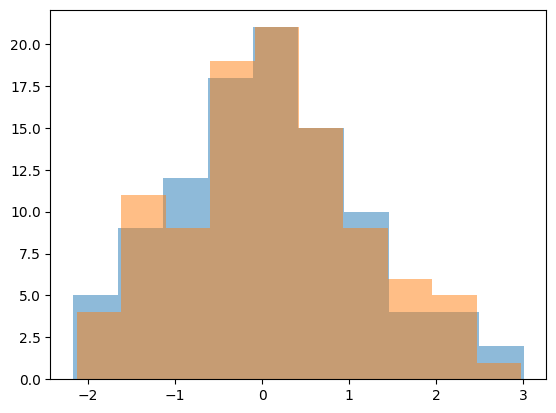

In [50]:
plt.hist(vec_pca[0], alpha=0.5, label="vec")
plt.hist(lda_pca[0], alpha=0.5, label="lda")

In [32]:
# turn torch shape into total number of activations
def num_acts(acts):
    return acts.shape[0] * acts.shape[1]

# memory usage for float32
print(num_acts(pos) * 4 / 1024 / 1024, "MB")

15.625 MB


In [73]:
behavior = "sycophancy"
pos, neg = [*get_acts(SteeringSettings(behavior=behavior), 12)]

tensor(0.0413) tensor(-1.6531e-08) tensor(0.9991)


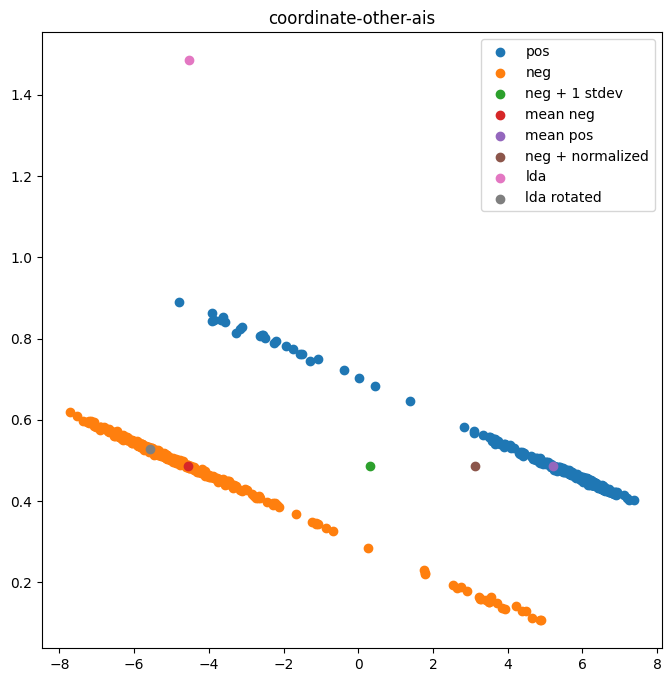

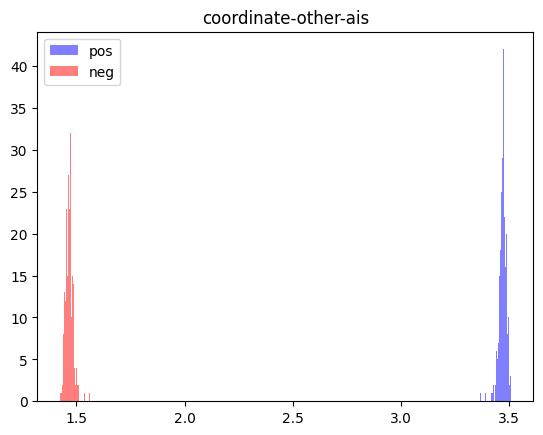

tensor(0.0591) tensor(7.4506e-09) tensor(0.9983)


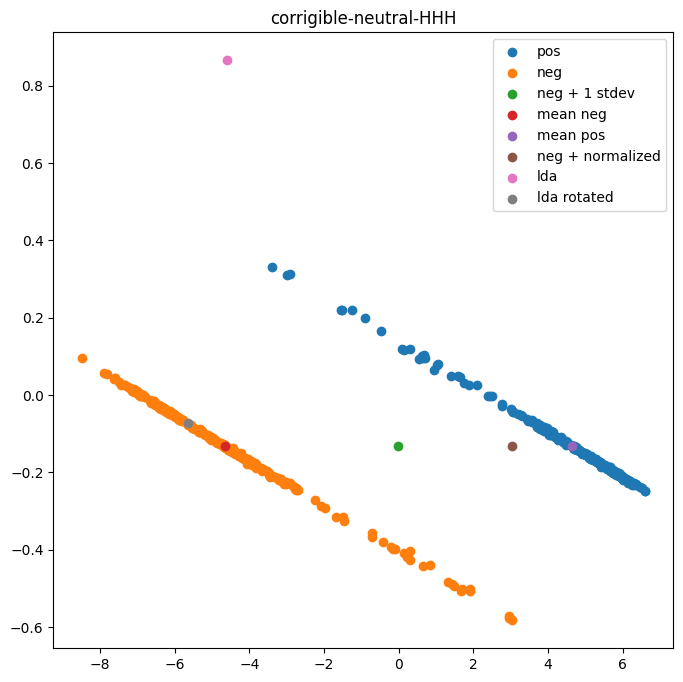

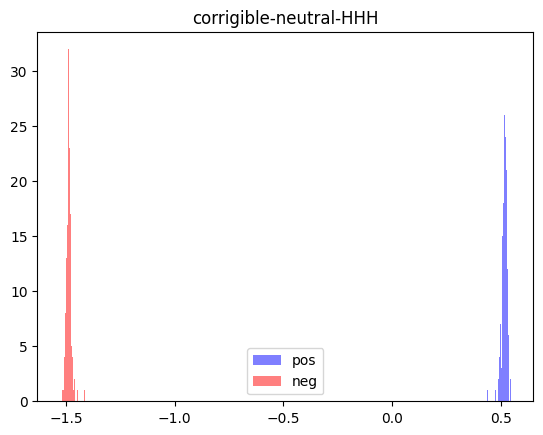

tensor(0.0545) tensor(1.1176e-08) tensor(0.9985)


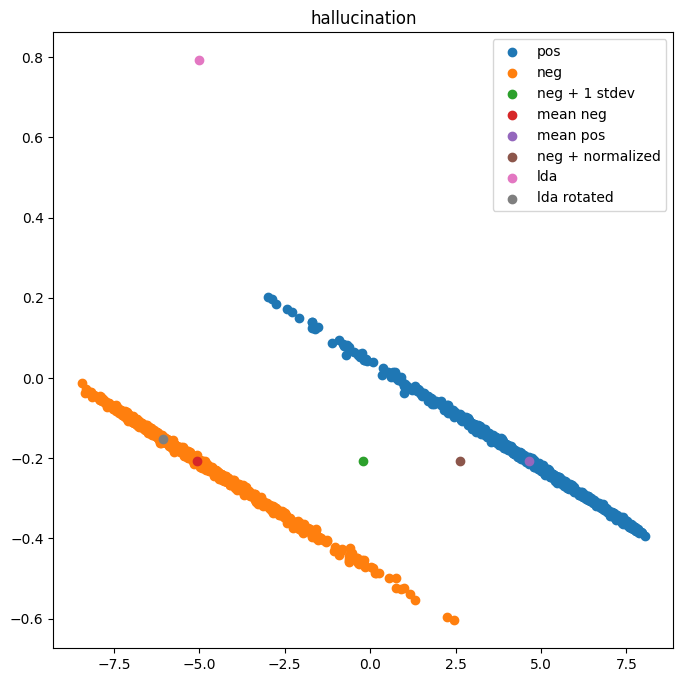

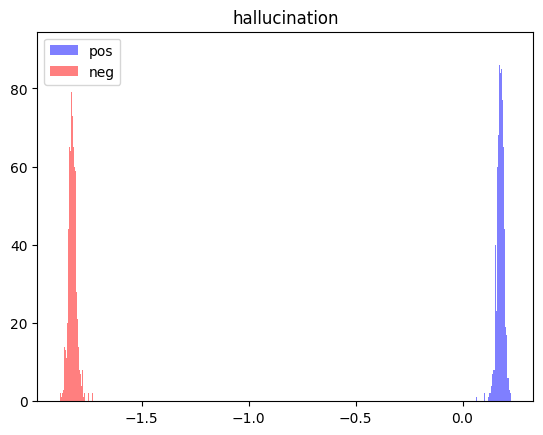

tensor(0.0706) tensor(-1.8626e-09) tensor(0.9975)


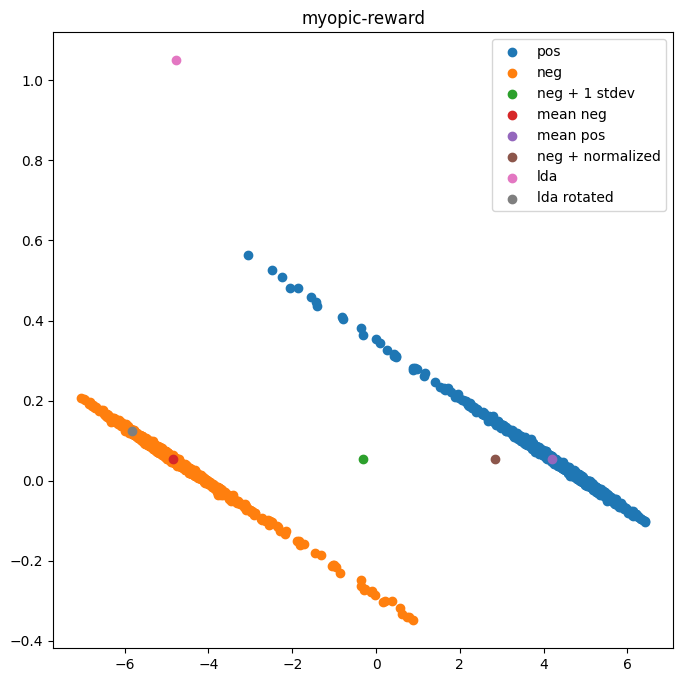

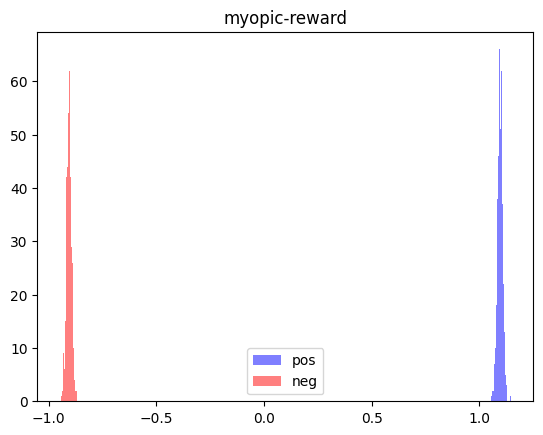

tensor(0.0634) tensor(6.0536e-09) tensor(0.9980)


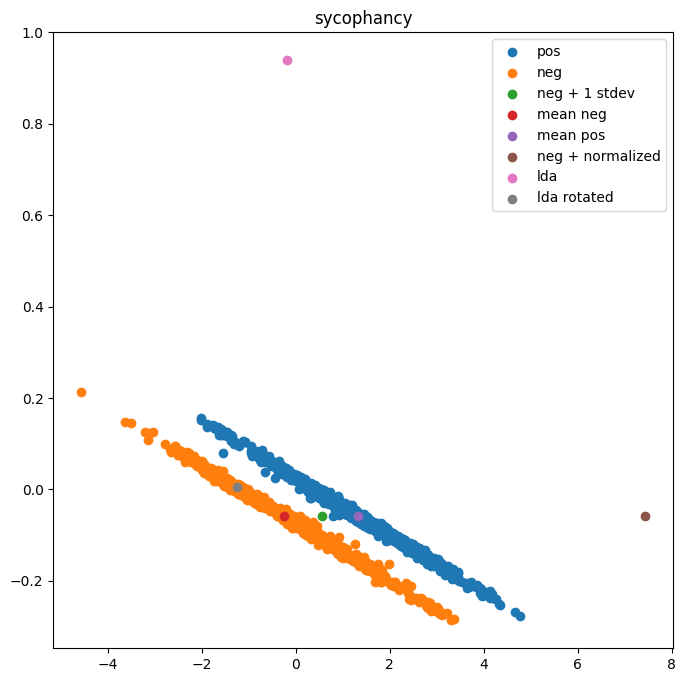

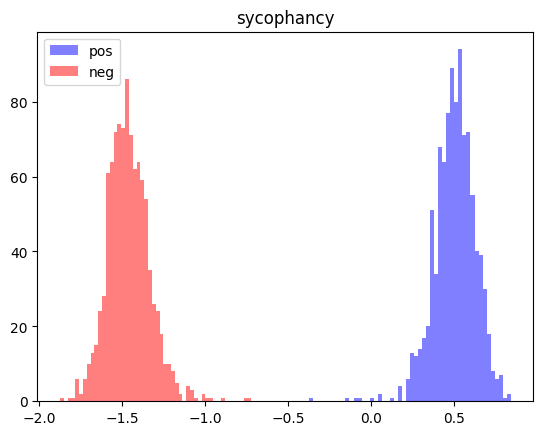

tensor(0.1395) tensor(-9.0804e-09) tensor(0.9902)


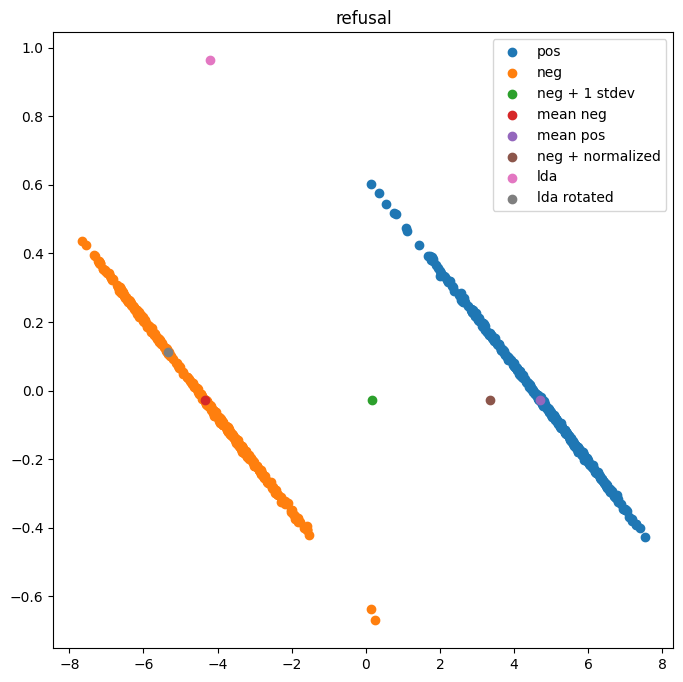

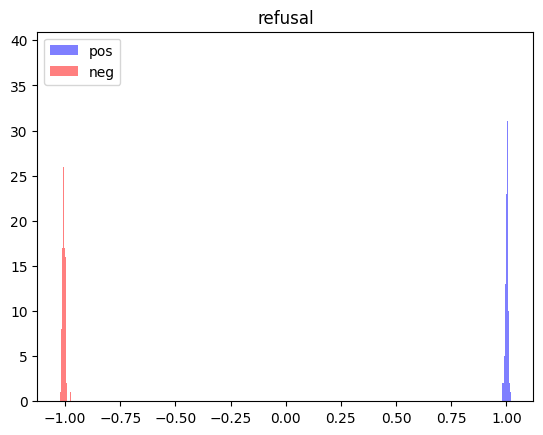

In [66]:
for behavior in ALL_BEHAVIORS:
    pos, neg = [*get_acts(SteeringSettings(behavior=behavior), 12)]
    vec, nvec = get_vec(behavior)
    lda, precision, fitter = fit_lda(pos, neg, vec)
    

    mean_pos = t.mean(pos, dim=0)
    mean_neg = t.mean(neg, dim=0)
    diff = mean_pos - mean_neg


    v = lda / t.norm(lda)


    # # project pos, neg, and vec onto v
    # pos_proj = t.matmul(pos, v)
    # neg_proj = t.matmul(neg, v)
    # vec_proj = t.matmul(vec[None], v)

    # # plot the histograms
    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # ax.hist(pos_proj.numpy(), bins=50, color="blue", alpha=0.5, label="pos")
    # ax.hist(neg_proj.numpy(), bins=50, color="red", alpha=0.5, label="neg")
    # ax.hist(vec_proj.numpy(), bins=50, color="green", alpha=0.5, label="vec")
    # ax.legend()
    # ax.set_title(behavior)
    # plt.show()


    u = diff / t.norm(diff)

    # project pos, neg, and vec onto u
    pos_proj = t.matmul(pos, u)
    neg_proj = t.matmul(neg, u)
    vec_proj = t.matmul(vec[None], u)

    # # plot the histograms
    # fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    # ax.hist(pos_proj.numpy(), bins=50, color="blue", alpha=0.5, label="pos")
    # ax.hist(neg_proj.numpy(), bins=50, color="red", alpha=0.5, label="neg")
    # ax.hist(vec_proj.numpy(), bins=50, color="green", alpha=0.5, label="vec")
    # ax.legend()
    # ax.set_title(behavior)
    # plt.show()



    # find orthonormal basis for span of u and v
    v_perp_u = v - t.dot(v, u) * u
    v_perp_u = v_perp_u / t.norm(v_perp_u)

    print(u @ v, u @ v_perp_u, v @ v_perp_u)

    # project pos, neg, and vec onto v_perp_u
    pos_proj2 = t.matmul(pos, v_perp_u)
    neg_proj2 = t.matmul(neg, v_perp_u)
    vec_proj2 = t.matmul(vec[None], v_perp_u)

    diff_proj = t.matmul(diff[None], u)
    diff_proj2 = t.matmul(diff[None], v_perp_u)

    nvec_proj = t.matmul(nvec[None], u)
    nvec_proj2 = t.matmul(nvec[None], v_perp_u)

    lda_proj = t.matmul(v[None], u)
    lda_proj2 = t.matmul(v[None], v_perp_u)

    ldar = (v @ u) * v_perp_u - (v @ v_perp_u) * u
    ldar_proj = t.matmul(ldar[None], u)
    ldar_proj2 = t.matmul(ldar[None], v_perp_u)

    o_x, o_y = t.mean(neg_proj), t.mean(neg_proj2)

    # scatterplot of _proj and _proj2
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(pos_proj, pos_proj2, label="pos")
    ax.scatter(neg_proj, neg_proj2, label="neg")

    ax.scatter(o_x + vec_proj, o_y + vec_proj2, label="neg + 1 stdev")
    ax.scatter(o_x, o_y, label="mean neg")
    ax.scatter(o_x + diff_proj, o_y + diff_proj2, label="mean pos")
    ax.scatter(o_x + nvec_proj, o_y + nvec_proj2, label="neg + normalized")
    ax.scatter(o_x + lda_proj, o_y + lda_proj2, label="lda")
    ax.scatter(o_x + ldar_proj, o_y + ldar_proj2, label="lda rotated")
    ax.legend()
    ax.set_title(behavior)
    plt.show()

    plt.hist(pos @ lda, bins=50, color="blue", alpha=0.5, label="pos")
    plt.hist(neg @ lda, bins=50, color="red", alpha=0.5, label="neg")
    plt.legend()
    plt.title(behavior)
    plt.show()





In [88]:
# cosine similarity of vec and diff
print((vec @ diff) / (t.norm(vec) * t.norm(diff)))

print((nvec @ diff) / (t.norm(nvec) * t.norm(diff)))

print((nvec @ vec) / (t.norm(nvec) * t.norm(vec)))

tensor(1.)
tensor(1.)
tensor(1.)


In [1]:
behavior = "myopic-reward"
pos, neg = [*get_acts(SteeringSettings(behavior=behavior), 13)]
editor = get_steering_eraser(behavior, 13, "Llama-2-7b-chat-hf", 
                logit=False, device=pos.device, prefix="quad")
neg_ed = editor.transport(neg, source_z=0, target_z=1)
neg_ed.shape

NameError: name 'get_acts' is not defined

tensor(0.0823) tensor(-6.5193e-09) tensor(0.9966)


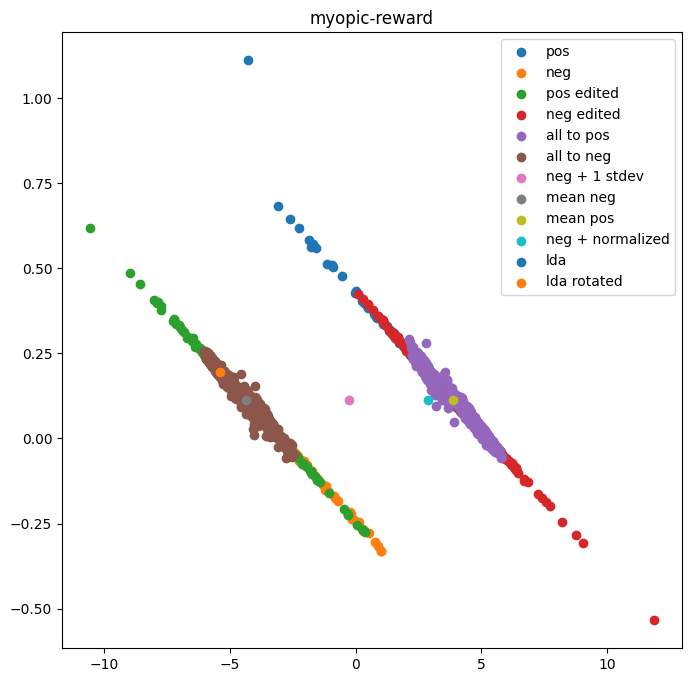

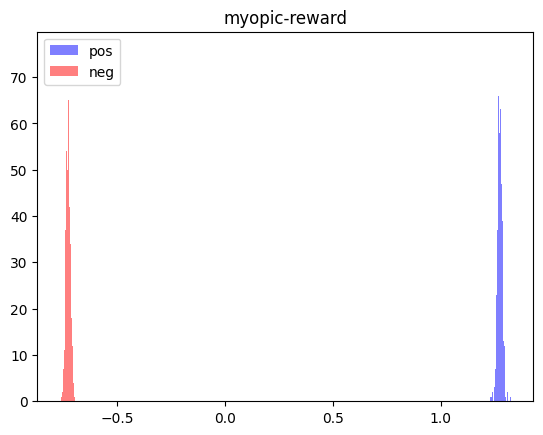

In [15]:
for behavior in ["myopic-reward"]:
    pos, neg = [*get_acts(SteeringSettings(behavior=behavior), 13)]
    all_acts = t.cat([pos, neg], dim=0)
    vec, nvec = get_vec(behavior, layer=13)
    lda, precision, fitter = fit_lda(pos, neg, vec)
    
    editor = get_steering_eraser(behavior, 13, "Llama-2-7b-chat-hf", 
                logit=False, device=pos.device, prefix="quad")

    mean_pos = t.mean(pos, dim=0)
    mean_neg = t.mean(neg, dim=0)
    diff = mean_pos - mean_neg

    pos_ed = editor.transport(pos, source_z=1, target_z=0).to(pos.dtype)
    neg_ed = editor.transport(neg, source_z=0, target_z=1).to(neg.dtype)

    all_to_pos = editor.transport(all_acts, source_z=2, target_z=1).to(pos.dtype)
    all_to_neg = editor.transport(all_acts, source_z=2, target_z=0).to(neg.dtype)

    v = lda / t.norm(lda)
    u = diff / t.norm(diff)

    # find orthonormal basis for span of u and v
    v_perp_u = v - t.dot(v, u) * u
    v_perp_u = v_perp_u / t.norm(v_perp_u)
    print(u @ v, u @ v_perp_u, v @ v_perp_u)

    # project pos, neg, and vec onto u
    pos_proj = t.matmul(pos, u)
    neg_proj = t.matmul(neg, u)
    vec_proj = t.matmul(vec[None], u)

    # project pos, neg, and vec onto v_perp_u
    pos_proj2 = t.matmul(pos, v_perp_u)
    neg_proj2 = t.matmul(neg, v_perp_u)
    vec_proj2 = t.matmul(vec[None], v_perp_u)

    pos_ed_proj = t.matmul(pos_ed, u)
    neg_ed_proj = t.matmul(neg_ed, u)
    pos_ed_proj2 = t.matmul(pos_ed, v_perp_u)
    neg_ed_proj2 = t.matmul(neg_ed, v_perp_u)

    all_to_pos_proj = t.matmul(all_to_pos, u)
    all_to_neg_proj = t.matmul(all_to_neg, u)
    all_to_pos_proj2 = t.matmul(all_to_pos, v_perp_u)
    all_to_neg_proj2 = t.matmul(all_to_neg, v_perp_u)

    diff_proj = t.matmul(diff[None], u)
    diff_proj2 = t.matmul(diff[None], v_perp_u)

    nvec_proj = t.matmul(nvec[None], u)
    nvec_proj2 = t.matmul(nvec[None], v_perp_u)

    lda_proj = t.matmul(v[None], u)
    lda_proj2 = t.matmul(v[None], v_perp_u)

    ldar = (v @ u) * v_perp_u - (v @ v_perp_u) * u
    ldar_proj = t.matmul(ldar[None], u)
    ldar_proj2 = t.matmul(ldar[None], v_perp_u)

    o_x, o_y = t.mean(neg_proj), t.mean(neg_proj2)

    # scatterplot of _proj and _proj2
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.scatter(pos_proj, pos_proj2, label="pos")
    ax.scatter(neg_proj, neg_proj2, label="neg")
    ax.scatter(pos_ed_proj, pos_ed_proj2, label="pos edited")
    ax.scatter(neg_ed_proj, neg_ed_proj2, label="neg edited")
    ax.scatter(all_to_pos_proj, all_to_pos_proj2, label="all to pos")
    ax.scatter(all_to_neg_proj, all_to_neg_proj2, label="all to neg")

    ax.scatter(o_x + vec_proj, o_y + vec_proj2, label="neg + 1 stdev")
    ax.scatter(o_x, o_y, label="mean neg")
    ax.scatter(o_x + diff_proj, o_y + diff_proj2, label="mean pos")
    ax.scatter(o_x + nvec_proj, o_y + nvec_proj2, label="neg + normalized")
    ax.scatter(o_x + lda_proj, o_y + lda_proj2, label="lda")
    ax.scatter(o_x + ldar_proj, o_y + ldar_proj2, label="lda rotated")
    ax.legend()
    ax.set_title(behavior)
    plt.show()

    plt.hist(pos @ lda, bins=50, color="blue", alpha=0.5, label="pos")
    plt.hist(neg @ lda, bins=50, color="red", alpha=0.5, label="neg")
    plt.legend()
    plt.title(behavior)
    plt.show()



